In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from typing import List, Tuple

def find_pdb_mapping(reference_sequence, pdb_sequence) -> List[Tuple[str, int]]:
    # Write your code here
    
    reference_list = list(reference_sequence)
    pdb_mapping = [None] * len(pdb_sequence)
    
    i_pdb = 0
    for i, aa_ref in enumerate(reference_list):
        
        pos, aa_pdb = pdb_sequence[i_pdb]
        
        if aa_ref == aa_pdb:
            pdb_mapping[i_pdb] = (pos, i)
            i_pdb += 1
        
    return pdb_mapping

# Verify conditional circuit generation

We have previously trained a neural network known as a conditional variational autoencoder on genetic circuits. The conditioning variable was made to be one of the characteristics of the genetic circuit's dynamics, for example the sensitivity of the circuit to a signal. While the distributions for each class of conditional variables differ in the AI-generated circuits, the verification of their ground-truth label is still necessary to assess the validity of the conditionality.

## Imports

In [2]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from evoscaper.model.evaluation import calc_prompt_adherence
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.scripts.verify import verify
from evoscaper.utils.dataset import embellish_data
from evoscaper.utils.math import arrayise
from evoscaper.utils.preprocess import make_datetime_str, format_with_subscript
from evoscaper.utils.visualise import vis_sampled_histplot, create_network_inset, make_nx_weights, visualize_dimred_2d_custom_labels, visualize_dimred_adapt_sp
from common import scale_norm

from functools import partial
import os
import json
import sys
import numpy as np
import jax
import jax.numpy as jnp
from sklearn.metrics import r2_score

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


np.random.seed(0)
PRNG = jax.random.PRNGKey(0)

jax.devices()

# jupyter nbconvert --to notebook --execute 02_cvae_verify.ipynb --output=02_cvae_verify_2.ipynb --ExecutePreprocessor.timeout=-1



xla_bridge.py:backends():900: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA INFO
xla_bridge.py:backends():900: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory INFO


[cuda(id=0), cuda(id=1)]

# Use verify function

In [3]:
# hpos = pd.Series(load_json_as_dict('data/01_cvae/2025_01_21__15_09_53/hpos_all.json'))
 
# fn_saves = os.path.join('weight_saves', '01_cvae',
#                         # '2024_12_19__16_10_53_saves_hs16_ls32_nlayers2_adam')
#                         # 'saves_2025_01_14__16_43_17_prec_sens')
#                         # 'saves_2025_01_14__17_44_21_sens')
#                         # 'saves_2025_01_17__16_01_57_sens_no_cat')
#                         'saves_2025_01_21__22_40_13_no_cat_sens_prec')
# fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_09__15_33_42_adapt')
# fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_09__21_26_05_prec_sens') 

use_run = True
dir_loaded_02 = None # 'data/cvae_multi/2025_09_07__17_39_09/batch_results/batch_0'
# dir_src = os.path.join('data', 'cvae_multi', '2025_09_07__17_39_09')
# midx = 112
# fn_saves = os.path.join(dir_src, f'cvae_scan/hpo_{midx}', os.listdir(os.path.join(dir_src, f'cvae_scan/hpo_{midx}'))[0])
# hpos = pd.DataFrame(load_json_as_dict(os.path.join(dir_src, 'df_hpos.json'))).iloc[-1]
# for k in hpos.index:
#     if k.startswith('file'):
#         hpos.loc[k] = hpos[k].replace('notebooks/', '')

# dir_src = os.path.join('data', '01_cvae', '2025_09_03__14_28_51')
# fn_saves = os.path.join(dir_src, 'saves_2025_09_03__14_28_51_ds0211_a_hs32_nl3_KL2e4_cont01ts095pd3_lr1e3_teva98_seeda25_seedtr12')
# dir_loaded_02 = os.path.join('data', '02_cvae_verify', '2025_03_20__14_42_23')
# dir_src = os.path.join('data', '01_cvae', '2025_03_20__14_23_17')
# fn_saves = os.path.join(dir_src, 'saves_2025_03_20__14_23_17_ds0129_a2_hs32_nl3_KL2e4_cont01ts095pd3_lr1e3_teva98')
# dir_src = os.path.join('data', '01_cvae', '2025_09_18__17_25_34')
# fn_saves = os.path.join(dir_src, 'saves_2025_09_18__17_25_34_ds0211_abin_hs32_nl3_KL2e4_nocont_lr1e3_teva98_seeda0_seedtr0')
dir_src = os.path.join('data', '01_cvae', '2025_11_27__17_15_15')
fn_saves = os.path.join(dir_src, 'saves_2025_11_27__17_15_15_ds0211_r_hs32_nl3_KL2e4_nocont_lr1e3_teva98_seeda25_seedtr12')  # Dataset `2025_02_11__13_56_51' Response time + kl = 2e-4 + seed 25 + seedtr 12 + nocont + teva = 0.98

hpos = pd.Series(load_json_as_dict(os.path.join(dir_src, 'hpos_all.json')))
saves_loaded = load_json_as_dict(fn_saves)
top_write_dir = os.path.join('data', '02_cvae_verify', make_datetime_str())
(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    params, encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos)

if not os.path.exists(top_write_dir):
    os.makedirs(top_write_dir)
    print('top_write_dir:', top_write_dir)
    cfg = {'fn_saves': fn_saves,
           'dir_loaded_02': dir_loaded_02,
           'use_run': use_run}
    with open(os.path.join(top_write_dir, 'config.json'), 'w') as f:
        json.dump(cfg, f)

params = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
params = arrayise(params)

config_bio = load_json_as_dict(config_dataset.filenames_verify_config)
if 'base_configs_ensemble' in config_bio:
    val_config = config_bio['base_configs_ensemble']['generate_species_templates']
    val_config.update(config_bio['base_configs_ensemble']['mutation_effect_on_interactions_signal'])
else:
    val_config = config_bio

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


top_write_dir: data/02_cvae_verify/2025_11_27__17_26_01


# Run

In [4]:
# hpos['eval_n_to_sample'] = int(3e4)
# hpos['eval_n_categories'] = 2 if ('Log sensitivity > 1' in config_dataset.objective_col) or ('Log precision > 0' in config_dataset.objective_col) else 10
val_config['simulation']['threshold_steady_states'] = 0.01
# val_config['simulation']['t1'] = 1000
# val_config['simulation']['tmax'] = 8000

n_to_sample = 10000 # int(hpos['eval_n_to_sample'])
n_categories = 10
# n_to_sample_per_cat = int(n_to_sample / (n_to_sample ** len(config_dataset.objective_col)))
input_species = data[data['sample_name'].notna()]['sample_name'].unique()
eval_cond_min = hpos.get('eval_cond_min', 0.0)  # -0.2)
eval_cond_max = hpos.get('eval_cond_max', 1.0)  #1.2)

# print('Going to sample', n_to_sample_per_cat,
#       'per category for a total of', n_to_sample, 'samples')

In [5]:
data['response_time'] = np.where(data['response_time'] < np.inf, data['response_time'], np.nan)

filt = (data['response_time'] < (0.8 * np.nanmax(data['response_time']))) & (data['sample_name'] == 'RNA_2')
# sns.histplot(data, x='response_time', bins=50)
data[filt].iloc[(np.argmax(np.log10(data[filt]['sensitivity'])))]['response_time'], np.log10(data[filt]['sensitivity']).max(), len(data[filt]), len(data[data['sample_name'] == 'RNA_2'])

(np.float64(1224.4898681641), np.float64(1.9242481231685546), 79590, 859930)

In [6]:
# config_bio['base_configs_ensemble']['mutation_effect_on_interactions_signal']['simulation']['threshold_steady_states'] = 0.01
# config_bio['base_configs_ensemble']['mutation_effect_on_interactions_signal']['simulation']['t1'] = 1000

In [7]:
if use_run:
    (
        analytics, ys, ts, y0m, y00s, ts0, fake_circuits, reverse_rates, model_brn, qreactions, input_species, z, sampled_cond
    ) = verify(params=params,
               rng=rng,
               decoder=decoder,
               cond=np.array([eval_cond_min, eval_cond_max]),
               n_categories=n_categories,
               config_bio=val_config,
               config_norm_y=config_norm_y,
               config_dataset=config_dataset,
               config_model=config_model,
               x_datanormaliser=x_datanormaliser,
               x_methods_preprocessing=x_methods_preprocessing,
               output_species=config_dataset.output_species,
               signal_species=config_dataset.signal_species,
               input_species=input_species,
               top_write_dir=top_write_dir,
               n_to_sample=n_to_sample,
               visualise=True,
               return_relevant=True,
               impose_final_range=(df[get_true_interaction_cols(df, config_dataset.x_type, remove_symmetrical=True, num_species=3)].min().min(),
                                   df[get_true_interaction_cols(df, config_dataset.x_type, remove_symmetrical=True, num_species=3)].max().max()))
else:
    # 2025_01_26__17_19_33
    # k = '2025_02_10__15_01_48'

    # 2025_02_25__12_42_34
    # k = '2025_02_24__18_16_57'

    # 2025_03_05__14_56_27
    # k = '2025_03_05__17_02_24'

    # 2025_03_10__15_02_46
    # k = '2025_03_10__17_29_26'

    # 2025_03_11__20_57_30
    # k = '2025_03_11__21_38_47'
    
    # 2025_03_12__22_14_51
    # k = '2025_03_13__21_21_52'
    
    # 2025_03_19__17_09_24
    # k = '2025_03_19__21_22_45'
    
    from evoscaper.utils.math import make_flat_triangle
    analytics = load_json_as_dict(os.path.join(dir_loaded_02, 'analytics.json'))
    ts = np.load(os.path.join(dir_loaded_02, 'ts.npy'))
    ys = np.load(os.path.join(dir_loaded_02, 'ys.npy'))
    y0m = np.load(os.path.join(dir_loaded_02, 'y0m.npy'))
    if 'batch' in os.path.basename(dir_loaded_02):
        i0 = int(1e4*2)
        i1 = None
        ys = ys[i0:i1]
        y0m = y0m[i0:i1]
        for k in analytics.keys():
            analytics[k] = analytics[k][i0:i1]
        fake_circuits = np.load(os.path.join(os.sep.join(dir_loaded_02.split(os.sep)[:-2]), 'fake_circuits.npy'))[i0:i1]
        fake_circuits = make_flat_triangle(fake_circuits)
        sampled_cond = np.load(os.path.join(os.sep.join(dir_loaded_02.split(os.sep)[:-2]), 'sampled_cond', f'sampled_cond_{midx}.npy'))
    else:
        fake_circuits = np.load(os.path.join(dir_loaded_02, 'fake_circuits.npy'))
        sampled_cond = np.load(os.path.join(dir_loaded_02, 'sampled_cond.npy'))
    
    ts0 = np.array([])
    y00s = np.array([])
    

Simulating steady states for 10000 circuits for a max of 2000 time units


Steady states:  500  iterations.  6354  left to steady out.  0:00:32.879921
Steady states:  1000  iterations.  1406  left to steady out.  0:01:06.100192
Steady states:  1500  iterations.  286  left to steady out.  0:01:36.494830
Done:  0:02:11.385062
Steady states found after 2 mins and 11 secs. Now calculating signal response
Steady states:  500  iterations.  108  left to steady out.  0:00:42.381165
Steady states:  1000  iterations.  35  left to steady out.  0:01:16.912059
Steady states:  1500  iterations.  16  left to steady out.  0:01:47.749379
Done:  0:02:20.880387
Signal response found after 2 mins and 20 secs.
data/02_cvae_verify/2025_11_27__17_26_01


In [8]:
idxs_badsim = np.unique(np.where(ys < 0)[0])

ys[idxs_badsim] = np.nan
y0m[idxs_badsim] = np.nan
fake_circuits = np.array(fake_circuits.reshape(-1, fake_circuits.shape[-1]))
fake_circuits[idxs_badsim] = np.nan
fake_circuits = fake_circuits.reshape(*sampled_cond.shape[:2], fake_circuits.shape[-1])
    
for k in analytics.keys():
    analytics[k] = np.array(analytics[k])
    analytics[k][idxs_badsim] = np.nan
analytics['adaptation'] = calculate_adaptation(
    analytics['sensitivity'], analytics['precision'], alpha=2)
analytics['Adaptable'] = (analytics['Log sensitivity'] >= 0) & (analytics['Log precision'] >= 1)

ts.shape, ys.shape, y0m.shape, y00s.shape, ts0.shape

((200,), (10000, 200, 9), (10000, 1, 9), (10000, 200, 9), (200,))

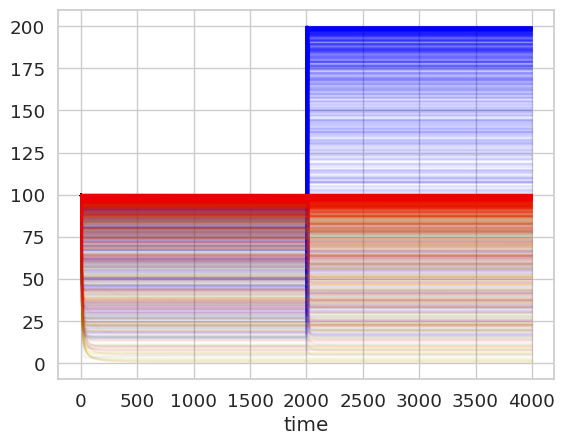

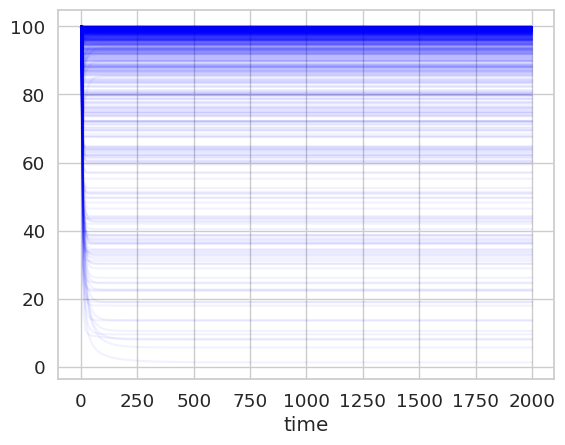

In [9]:
idx_output = -1
n_show = int(1e3)

if len(y00s):
    # plt.plot(np.repeat(ts[None, :], repeats=n_show, axis=0).T, ys[:n_show, :, -3].T, alpha=0.05, color='b')
    # plt.plot(np.repeat(ts[None, :], repeats=n_show, axis=0).T, ys[:n_show, :, -2].T, alpha=0.05, color='g')
    # plt.plot(np.repeat(ts[None, :], repeats=n_show, axis=0).T, ys[:n_show, :, -1].T, alpha=0.05, color='r')
    plt.plot(np.repeat(np.concatenate([ts0, ts+ts0.max()])[None, :], repeats=n_show, axis=0).T,
            np.concatenate([y00s[:n_show, :, -3].T, ys[:n_show, :, -3].T], axis=0), color='b', alpha=0.05)
    plt.plot(np.repeat(np.concatenate([ts0, ts+ts0.max()])[None, :], repeats=n_show, axis=0).T,
            np.concatenate([y00s[:n_show, :, -2].T, ys[:n_show, :, -2].T], axis=0), color='y', alpha=0.05)
    plt.plot(np.repeat(np.concatenate([ts0, ts+ts0.max()])[None, :], repeats=n_show, axis=0).T,
            np.concatenate([y00s[:n_show, :, -1].T, ys[:n_show, :, -1].T], axis=0), color='r', alpha=0.05)
    plt.xlabel('time')

    plt.figure()
    plt.plot(np.repeat(ts0[None, :], repeats=n_show, axis=0).T, y00s[:n_show, :, idx_output].T, alpha=0.05, color='b')
    plt.xlabel('time')

In [10]:
# print(data_writer.top_write_dir)
# data_writer.output(data=analytics, out_type='json', out_name='analytics')
# data_writer.output(data=ys, out_type='npy', out_name='ys')
# data_writer.output(data=ts, out_type='npy', out_name='ts')
# data_writer.output(data=y0m, out_type='npy', out_name='y0m')
# data_writer.output(data=fake_circuits, out_type='npy', out_name='fake_circuits')

In [11]:
idx_output = -1
idx_signal = -3
# idxs_viable = np.where((analytics['response_time'][:, idx_output] < 0.8*analytics['response_time'].max()) & (
#     analytics['overshoot'][:, idx_output] > 1e-3) & (
#         analytics['initial_steady_states'][:, idx_output] > 1))[0]
# df_max = pd.DataFrame(analytics['sensitivity'][:, idx_output], columns=['sensitivity'])
# df_max['overshoot'] = analytics['sensitivity'][:, idx_output]
# idx_max = df_max.iloc[idxs_viable]['overshoot'].idxmax()
idx_max = np.nanargmax(analytics['adaptation'][:, idx_output])
# idx_max = np.nanargmax(analytics['sensitivity'][:, idx_output])
# idx_max = np.argmax(analytics['overshoot'][:, idx_output])


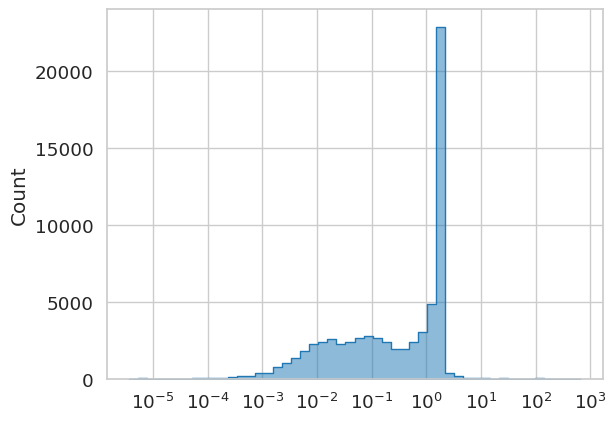

In [12]:
sns.histplot(analytics['sensitivity'][np.where(analytics['response_time'] < 1e2)[0]][:, idx_output], bins=50, element='step', log_scale=[True, False], alpha=0.5)
d = pd.DataFrame(analytics['sensitivity'][:, idx_output])
idxs_med = d[d[0].between(*np.median(analytics['sensitivity'][:, idx_output]) + np.array([-0.01, 0.01]))].index.to_numpy()
fake_circuits_f = fake_circuits.reshape(-1, fake_circuits.shape[-1])
# fake_circuits_f[idxs_med]

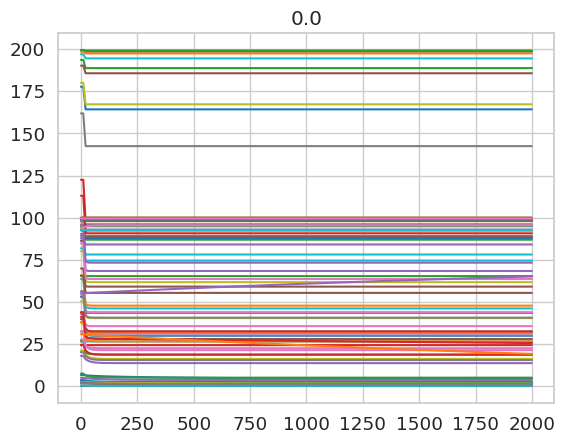

In [13]:
for i in idxs_med:

    plt.plot(ts, ys[i, :, -3:])
    plt.title(analytics['overshoot'][i, idx_output]/ analytics['initial_steady_states'][i, idx_output])
# plt.plot(np.repeat(ts[:, None], repeats=len(idxs_med), axis=-1), ys[idxs_med, :, idx_output].T, color='b')

(array([  0.        ,  -3.9203756 ,  -8.213795  ,   0.        ,
         -0.25514695, -18.995132  ], dtype=float32),
 np.float64(23.578887939453125))

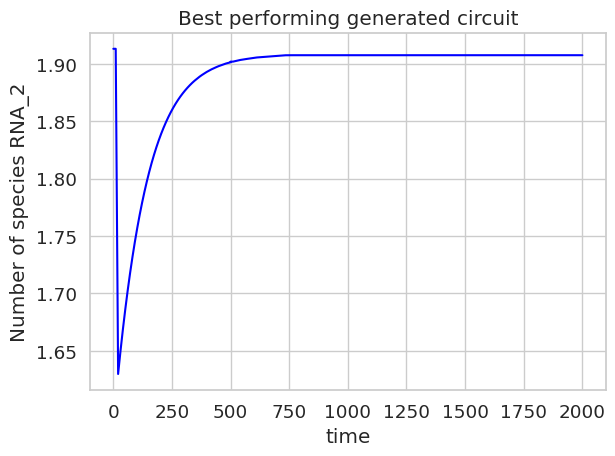

In [14]:
idx_signal = -3
plt.plot(ts, ys[idx_max, :, idx_output].T, color='b')
plt.xlabel('time')
plt.ylabel(f'Number of species {input_species[idx_output]}')
plt.title('Best performing generated circuit')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'best_performing_circuit.png'))
fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1)[idx_max], analytics['sensitivity'][idx_max, idx_output]


## Time series

0 [  0.          -3.9203756   -8.213795     0.          -0.25514695
 -18.995132  ]
1 [  0.          0.         -6.7647934   0.          0.        -19.134998 ]
2 [  0.         -4.4496465  -8.116407   -7.668772   -1.5187448 -18.274227 ]
3 [  0.          -6.110122    -8.092136     0.          -0.85775983
 -19.70872   ]
4 [  0.        -7.018104 -10.128632   0.         0.       -18.681078]
5 [  0.          0.         -9.7881565   0.          0.        -16.523655 ]
6 [  0.          -4.084297    -7.1962156    0.          -0.25936228
 -16.032682  ]
7 [  0.         0.        -8.881854   0.         0.       -15.182662]
8 [  0.         0.        -8.847352   0.         0.       -15.099538]
9 [  0.          0.        -11.566742    0.         -3.9793136 -18.140541 ]


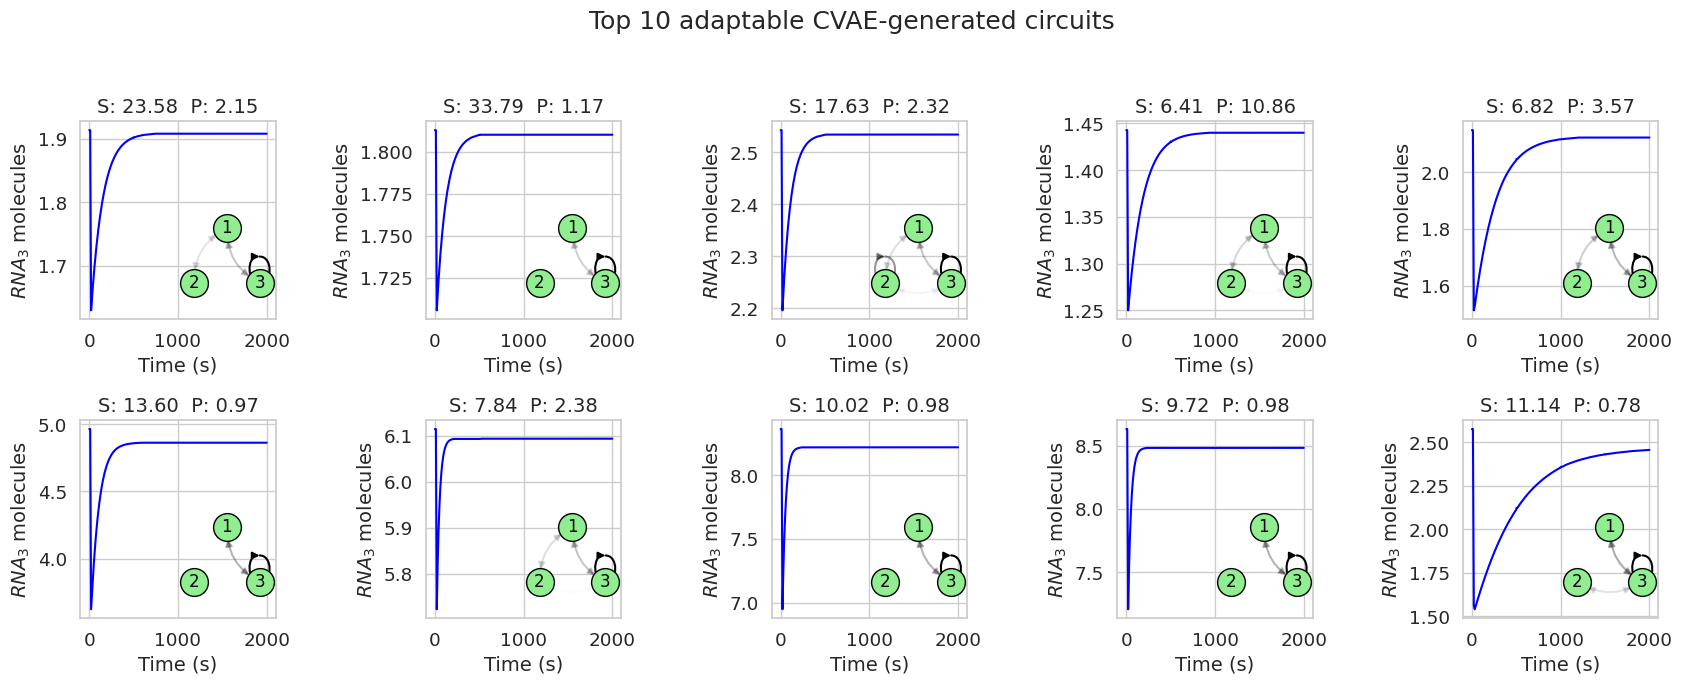

In [15]:
n_top = 10
# a = np.array(analytics['adaptation'])
# a = np.where(np.isfinite(analytics['adaptation']) & (np.array(analytics['response_time']) < 750), analytics['adaptation'], np.nan)
# a = np.where(np.isfinite(analytics['adaptation']) & (np.array(analytics['initial_steady_states']) > 10), analytics['adaptation'], 0)
a = np.where(np.isfinite(analytics['adaptation']) & (
    analytics['overshoot'] / analytics['initial_steady_states'] > 0.05) & (
        analytics['response_time'] < (0.9 * analytics['response_time'].max())
        ) & (analytics['initial_steady_states'] > 0), analytics['adaptation'], 0)
# idxs_top_adapt = np.argsort(a[:, idx_output])[:n_top]
idxs_top_adapt = np.argsort(a[:, idx_output])[-n_top:][::-1]
nrows = 2
ncols = int(np.ceil(n_top / nrows))


fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                        figsize=(ncols * 3.5, nrows * 3.5))
t_plotmax = int(30000*0.8)
for i, idx in enumerate(idxs_top_adapt):
    ax = axs[i // ncols, i % ncols]
    ax.plot(ts, ys[idx, :, idx_output].T, color='b')
    # ax.plot(ts, ys[idx, :, idx_signal].T, color='r')
    # ax.set_ylim([0, 410])
    w = fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1)[idx]
    create_network_inset(fig, ax, width=0.9, height=0.9, edge_weights=make_nx_weights(
        w, n_nodes=3), node_color='lightgreen')
    print(i, w)
    # ax.set_title(f'Adaptation = {a[idx, idx_output]:.2f}\nS = {analytics["sensitivity"][idx, idx_output]:.2f} P = {analytics["precision"][idx, idx_output]:.2f}')
    ax.set_title(f'S: {analytics["sensitivity"][idx, idx_output]:.2f}  P: {analytics["precision"][idx, idx_output]:.2f}', fontsize=14)
    ax.set_xlabel('Time (s)', fontsize=14)
    ax.set_ylabel(f'$RNA_3$ molecules', fontsize=14)

plt.suptitle(f'Top {n_top} adaptable CVAE-generated circuits', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(top_write_dir,
            'best_performing_circuits_networks.png'), dpi=300, bbox_inches='tight', transparent=True)

# w, fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1)[idxs_top_adapt] #, analytics['sensitivity'][idx_max, idx_output]

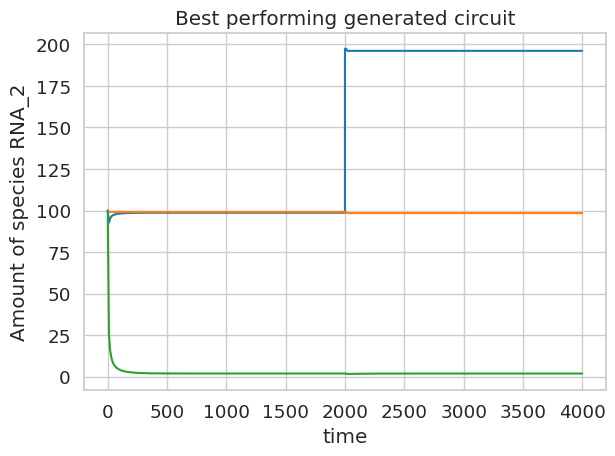

In [16]:
idx_signal = -3
idx_output = -1 
if len(y00s):
    plt.plot(np.concatenate([ts0, ts+ts0.max()]),
            np.concatenate([y00s[idx_max, :, -3:].T, ys[idx_max, :, -3:].T], axis=-1).T)
    plt.xlabel('time')
    plt.ylabel(f'Amount of species {input_species[idx_output]}')
    plt.title('Best performing generated circuit')

    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, 'best_performing_circuit_full.png'))
    fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1)[idx_max], analytics['sensitivity'][idx_max, idx_output], analytics['adaptation'][idx_max, idx_output], analytics['overshoot'][idx_max, idx_output], analytics['response_time'][idx_max, idx_output]

# Visualise

In [17]:
from sklearn.metrics import r2_score
from copy import deepcopy

vis_test_r2 = False
if vis_test_r2:
    from evoscaper.utils.dataset import prep_data, concat_conds

    fn_test = config_dataset.filenames_verify_table 
    fn_test = fn_test if os.path.exists(fn_test) else os.path.join('..', fn_test)
    data_test = pd.read_csv(fn_test) if fn_test.endswith(
        '.csv') else pd.read_json(fn_test)

    # if ('Log ruggedness (adaptation)' in config_dataset.objective_col) and ('Log ruggedness (adaptation)' in df_test.columns):
    df_test = prep_data(data_test, config_dataset.output_species,
                        config_dataset.objective_col, x_cols, config_filter)
    x_test = np.array(x_datanormaliser.create_chain_preprocessor(x_methods_preprocessing)(
        np.concatenate([df_test[i].values[:, None] for i in x_cols], axis=1).squeeze()))

    y_datanormaliser2 = deepcopy(y_datanormaliser)
    cond_test = concat_conds(config_dataset.objective_col, df_test,
                                y_datanormaliser2, y_methods_preprocessing)

    fig, axes = plt.subplots(1, 1, figsize=(7, 6))
    train_modes = ['Training', 'Test data']
    for i, (xi, cond_i) in enumerate([[x, cond], [x_test, cond_test]]):
        train_mode = train_modes[i]

        pred_y = model(params, PRNG, xi, cond_i)

        g = sns.histplot(x=pred_y.flatten(), y=xi.flatten(), bins=200, palette='viridis', ax=axes,
                            label=train_mode, alpha=0.5, color='b' if i == 0 else 'r')
        axes.plot([0, 1], [0, 1], '--')
        axes.set_title(
            f'Actual vs. predicted decoded circuits\n$R^2$: {r2_score(xi.flatten(), pred_y.flatten()):.2f}')
        # axes[i].set_title(f'{train_mode} - Actual vs. predicted decoded circuits\n$R^2$: {r2_score(xi.flatten(), pred_y.flatten()):.2f}')
        axes.set_xlabel('Predicted circuit binding energy')
        axes.set_ylabel('Actual circuit binding energy')

        print(f'[{train_mode}] The R2 score is ',
                r2_score(xi.flatten(), pred_y.flatten()))
        print(f'[{train_mode}] The R2 score with weighted variance is ', r2_score(
            xi.flatten(), pred_y.flatten(), multioutput='variance_weighted'))

    plt.legend(train_modes, title='Data type', loc='lower right')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(top_write_dir, 'pred_vs_actual.png'),
                dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

/tmp/ipykernel_1345607/2281411420.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.histplot(x=pred_y.flatten(), y=x.flatten(), bins=200, palette='viridis', ax=axes, alpha=0.5, color='b')


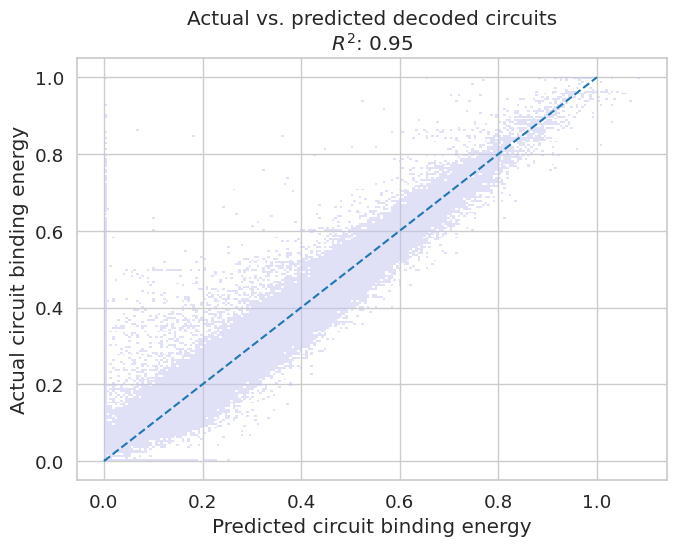

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(7, 6))

pred_y = model(params, PRNG, x, cond)

g = sns.histplot(x=pred_y.flatten(), y=x.flatten(), bins=200, palette='viridis', ax=axes, alpha=0.5, color='b')
axes.plot([0, 1], [0, 1], '--')
axes.set_title(
    f'Actual vs. predicted decoded circuits\n$R^2$: {r2_score(x.flatten(), pred_y.flatten()):.2f}')
# axes[i].set_title(f'{train_mode} - Actual vs. predicted decoded circuits\n$R^2$: {r2_score(x.flatten(), pred_y.flatten()):.2f}')
axes.set_xlabel('Predicted circuit binding energy')
axes.set_ylabel('Actual circuit binding energy')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(top_write_dir, 'pred_vs_actual_notest.png'),
            dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [19]:
# fig, axes = plt.subplots(1, 2, figsize=(2*6, 4))

# pred_y = model(params, PRNG, x, cond)

# g = sns.histplot(x=pred_y.flatten(), y=y.flatten(), bins=100, palette='viridis', ax=axes[0])
# axes[0].plot([0, 1], [0, 1], '--')
# axes[0].set_title(f'Training - Actual vs. predicted decoded circuits\n$R^2$: {r2_score(y.flatten(), pred_y.flatten()):.2f}')
# axes[0].set_xlabel('Predicted circuit binding energy')
# axes[0].set_ylabel('Actual circuit binding energy')

# print('[Training] The R2 score is ', r2_score(y.flatten(), pred_y.flatten()))
# print('[Training] The R2 score with weighted variance is ', r2_score(
#     y.flatten(), pred_y.flatten(), multioutput='variance_weighted'))

# pred_y_val = model(params, PRNG, x_val, cond_val)

# g = sns.histplot(x=pred_y_val.flatten(), y=y_val.flatten(), palette='viridis', ax=axes[1])
# axes[1].plot([0, 1], [0, 1], '--')
# axes[1].set_title(f'Validation data - Actual vs. predicted decoded circuits\n$R^2$: {r2_score(y_val.flatten(), pred_y_val.flatten()):.2f}')
# axes[1].set_xlabel('Predicted circuit binding energy')
# axes[1].set_ylabel('Actual circuit binding energy')

# print(f'[Validation] The $R^2$ score is ', r2_score(y_val.flatten(), pred_y_val.flatten()))
# print(f'[Validation] The $R^2$ score with weighted variance is ', r2_score(
#     y_val.flatten(), pred_y_val.flatten(), multioutput='variance_weighted'))

# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig(os.path.join(top_write_dir, 'parity.png'), transparent=True, dpi=300)

# plt.show()


In [20]:
category_array = np.concatenate([y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(
    sampled_cond[..., i], col=c)[..., None] for i, c in enumerate(config_dataset.objective_col)], axis=-1).reshape(np.prod(sampled_cond.shape[:-1]), -1)
# category_array = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(sampled_cond, config_dataset.objective_col[0]).reshape(np.prod(sampled_cond.shape[:-1]), -1)

In [21]:
# output_species = ['RNA_1', 'RNA_2']
# all_species = [str(i) for i in range(np.array(analytics['sensitivity']).shape[-1] - len(input_species))] + list(input_species)
output_species = ['RNA_2', 'RNA_3']
all_species = [str(i) for i in range(np.array(analytics['sensitivity']
                                              ).shape[-1] - len(input_species))] + ['RNA_1'] + output_species

if 'Log sensitivity' not in analytics:
    analytics['Log sensitivity'] = np.log10(analytics['sensitivity'])
    analytics['Log precision'] = np.log10(analytics['precision'])


idx_sens = 0
if set(['sensitivity', 'Log sensitivity', 'Log sensitivity > 0']).intersection(set(config_dataset.objective_col)):
    s_obj = set(['sensitivity', 'Log sensitivity', 'Log sensitivity > 0']
                ).intersection(set(config_dataset.objective_col)).pop()
    idx_sens = config_dataset.objective_col.index(s_obj)
    vis_sampled_histplot(analytics['sensitivity'], all_species, output_species, category_array[:, idx_sens, None],
                         title=f'Sensitivity of generated circuits', x_label=f'Log10 of sensitivity to signal {config_dataset.signal_species[0]}', multiple='layer',
                         show=False, save_path=os.path.join(top_write_dir, 'hist_sens_layer.png'))

    vis_sampled_histplot(analytics['sensitivity'], all_species, output_species, category_array[:, idx_sens, None],
                         title=f'Sensitivity of generated circuits', x_label=f'Log10 of sensitivity to signal {config_dataset.signal_species[0]}', multiple='fill',
                         show=False, save_path=os.path.join(top_write_dir, 'hist_sens_fill.png'))

    vis_sampled_histplot(analytics['sensitivity'], all_species, output_species, category_array[:, idx_sens, None],
                         title=f'Sensitivity of generated circuits', x_label=f'Log10 of sensitivity to signal {config_dataset.signal_species[0]}', multiple='layer',
                         show=False, save_path=os.path.join(top_write_dir, 'hist_sens_kde.png'),
                         f=sns.kdeplot, log_scale=[True, False], fill=False)

if len(config_dataset.objective_col) <= 2:

    vis_sampled_histplot(analytics['sensitivity'], all_species, output_species, category_array,
                         title=f'Sensitivity of generated circuits', x_label=f'Log10 of sensitivity to signal {config_dataset.signal_species[0]}', multiple='layer',
                         show=False, save_path=os.path.join(top_write_dir, 'hist_sens_kde_all.png'),
                         f=sns.kdeplot, log_scale=[True, False], fill=False)

In [22]:
if len(config_dataset.objective_col) <= 2:
    c = category_array
else:
    c = category_array[:, idx_sens, None]

vis_sampled_histplot(analytics['adaptation'], all_species, output_species, sampled_cond.reshape(-1, sampled_cond.shape[-1]),  # c,
                     title=f'Adaptation of generated circuits', x_label=f'Adaptation', multiple='layer',
                     show=False, save_path=os.path.join(top_write_dir, 'hist_adapt_layer.png'),
                     log_scale=[False, False], vline_uniqs=np.unique(c))

vis_sampled_histplot(analytics['adaptation'], all_species, output_species, sampled_cond.reshape(-1, sampled_cond.shape[-1]),  # c,
                     title=f'Adaptation of generated circuits', x_label=f'Adaptation', multiple='fill',
                     show=False, save_path=os.path.join(top_write_dir, 'hist_adapt_fill.png'),
                     log_scale=[False, False], vline_uniqs=np.unique(c))

vis_sampled_histplot(analytics['adaptation'], all_species, output_species, c,  # sampled_cond.reshape(-1, sampled_cond.shape[-1]), # c,
                     title=f'Adaptation of generated circuits', x_label=f'Adaptation', multiple='layer',
                     show=False, save_path=os.path.join(top_write_dir, 'hist_adapt_kde.png'),
                     f=sns.kdeplot, log_scale=[False, False], fill=False, include_hue_vlines=True, vline_uniqs=np.unique(c))

# Norm
adapt_norm = scale_norm(
    analytics['adaptation'], key='adaptation', data=df, vmin=0, vmax=1)
idxs_inrange = np.where(adapt_norm[..., idx_output] > -0.4)
vis_sampled_histplot(adapt_norm[idxs_inrange], all_species, output_species,
                     sampled_cond.reshape(-1, sampled_cond.shape[-1])[idxs_inrange],
                     title=f'Adaptation of generated circuits', x_label=f'Adaptation', multiple='layer',
                     show=False, save_path=os.path.join(top_write_dir, 'hist_adapt_kde_norm.png'),
                     f=sns.kdeplot, log_scale=[False, False], fill=False, include_hue_vlines=True, vline_uniqs=np.unique(sampled_cond),
                     hue_label='Prompt')
vis_sampled_histplot(adapt_norm[idxs_inrange], all_species, output_species,
                     sampled_cond.reshape(-1, sampled_cond.shape[-1])[idxs_inrange],
                     title=f'Adaptation of generated circuits', x_label=f'Adaptation', multiple='layer',
                     show=False, save_path=os.path.join(top_write_dir, 'hist_adapt_layer_norm.png'),
                     log_scale=[False, False], vline_uniqs=np.unique(c), hue_label='Prompt')

In [ ]:
config_dataset.objective_col

In [51]:
# Response time
vis_sampled_histplot(analytics['response_time'], all_species, output_species, c,  # sampled_cond.reshape(-1, sampled_cond.shape[-1]), # c,
                     title=f'Response time of generated circuits', x_label=f'Response time', multiple='layer',
                     show=False, save_path=os.path.join(top_write_dir, 'hist_resp_time_kde.png'),
                     f=sns.kdeplot, log_scale=[False, False], fill=False, include_hue_vlines=True, vline_uniqs=np.unique(c))
vis_sampled_histplot(analytics['response_time'], all_species, output_species, c,
                     title=f'Response time of generated circuits', x_label=f'Response time', multiple='layer',
                     show=False, save_path=os.path.join(top_write_dir, 'hist_resp_time_layer.png'),
                     log_scale=[False, True], fill=False, vline_uniqs=np.unique(c), hue_label='Prompt')

# Norm
resptime_norm = scale_norm(
    analytics['response_time'], key='response_time', data=df, vmin=0, vmax=1)
idxs_inrange = np.where(resptime_norm[..., idx_output] > -0.4)
vis_sampled_histplot(resptime_norm[idxs_inrange], all_species, output_species,
                     sampled_cond.reshape(-1, sampled_cond.shape[-1])[idxs_inrange],
                     title=f'Response time of generated circuits', x_label=f'Response time', multiple='layer',
                     show=False, save_path=os.path.join(top_write_dir, 'hist_resp_time_kde_norm.png'),
                     f=sns.kdeplot, log_scale=[False, False], fill=False, include_hue_vlines=True, vline_uniqs=np.unique(sampled_cond),
                     hue_label='Prompt')
vis_sampled_histplot(resptime_norm[idxs_inrange], all_species, output_species,
                     sampled_cond.reshape(-1, sampled_cond.shape[-1])[idxs_inrange],
                     title=f'Response time of generated circuits', x_label=f'Response time', multiple='layer',
                     show=False, save_path=os.path.join(top_write_dir, 'hist_resp_time_layer_norm.png'),
                     log_scale=[False, True], fill=False, vline_uniqs=np.unique(c), hue_label='Prompt')

One extra plot where adaptation kde is on [0, 1] scale

In [23]:
# def norm_adaptation_validated(adaptation_validated):

#     d = adaptation_validated
#     median = y_datanormaliser.metadata['adaptation']['median']
#     iqr = y_datanormaliser.metadata['adaptation']['iqr']

#     robust_scaled = (d - median) / iqr

#     max_val = np.nanmax(df['adaptation'])
#     min_val = np.nanmin(df['adaptation'])

#     # Prevent division by zero
#     scale = max_val - min_val
#     scale = jnp.where(scale == 0, 1.0, scale)

#     # Map to desired feature range
#     min_range, max_range = (0, 1)
#     adapt_norm = ((robust_scaled - y_datanormaliser.metadata['adaptation']['min_val']) / y_datanormaliser.metadata['adaptation']['scale']) * \
#         (max_range - min_range) + min_range

#     print(np.nanmin(adapt_norm), np.nanmax(adapt_norm))
#     print(np.nanmin(robust_scaled), np.nanmax(robust_scaled))

#     return adapt_norm


# adapt_norm = scale_norm(
#     np.array(analytics['adaptation']), key='adaptation', data=df, vmin=0, vmax=1)
y_datanormaliser2 = deepcopy(y_datanormaliser)
k_adapt = config_dataset.objective_col[0]  # 'adaptation'
adapt_norm = y_datanormaliser2.create_chain_preprocessor(y_methods_preprocessing)(
    np.array(analytics[k_adapt]), col=k_adapt, use_precomputed=True)
vis_sampled_histplot(adapt_norm, all_species, output_species, sampled_cond.reshape(-1, sampled_cond.shape[-1]),  # c,
                     title=f'Adaptation of generated circuits', x_label=k_adapt.capitalize(), multiple='layer',
                     show=False, save_path=os.path.join(top_write_dir, 'hist_adapt_kde2.png'),
                     f=sns.kdeplot, log_scale=[False, False], fill=False, include_hue_vlines=True, vline_uniqs=np.unique(sampled_cond.round(2)))

In [24]:
np.nanmax(adapt_norm)

np.float32(1.3175675)

## Diffs between distributions

/workdir/src/evoscaper/utils/dataset.py:109: RuntimeWarning: divide by zero encountered in log10
  data[k] != 0, np.log10(data[k]), zero_log_replacement)
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the approp

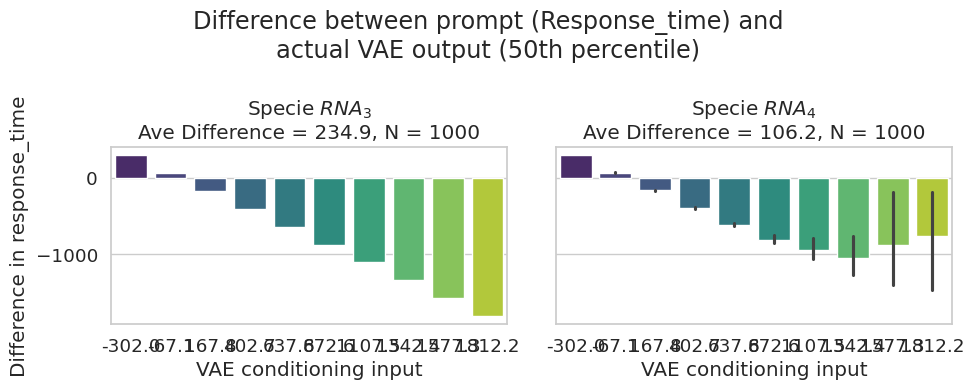

In [25]:
def plot_diffs(diffs_conditional_real_sens, objective_col, sampled_conds, ax, palette='viridis', f_plot=sns.barplot):
    f_plot(pd.DataFrame(diffs_conditional_real_sens.T, columns=sampled_conds.round(1).flatten(),  # [
                        ),
           palette=palette, ax=ax)
    ax.set_xlabel('VAE conditioning input')
    ax.set_ylabel(f'Difference in {objective_col}')
    
    
def calc_diffs(analytic_reshaped, n_categories, sampled_conds_rev_ii):
    
    diffs_conditional_real_sens = np.zeros((n_categories, 3))
    for cat in range(n_categories):
        diffs_conditional_real_sens[cat] = jnp.percentile(
            analytic_reshaped[cat][~np.isnan(analytic_reshaped[cat])], q=np.array([25, 50, 75]))
    diffs_conditional_real_sens = diffs_conditional_real_sens - sampled_conds_rev_ii  #[:, ii, None]
    return diffs_conditional_real_sens
    


# for k in ['sensitivity', 'precision', 'adaptation']:
#     analytics[k] = np.where(np.isnan(
#         analytics[k]), 0, analytics[k])
#     analytics[f'Log {k.split("_")[0]}'] = np.log10(analytics[k])
analytics = embellish_data(analytics)
n_objs = len(config_dataset.objective_col)
n_categories = int(fake_circuits.shape[0])
n_samples = int(analytics[list(analytics.keys())[0]].shape[0])

sampled_conds = sampled_cond.mean(axis=1)
sampled_conds_rev = np.array([y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(
    sampled_conds, c) for c in config_dataset.objective_col])[0]
for ii, k in enumerate(config_dataset.objective_col):
    if k not in analytics:
        print(f'The analytic {k} was not simulated in analytics')
        continue
    # sampled_conds = np.array(
    #     sorted(y_datanormaliser.metadata[k]['category_map'].values()))

    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    fig.subplots_adjust(hspace=0.3, top=0.8)
    for i, output_specie in enumerate(output_species):
        output_idx = all_species.index(output_specie)
        a = analytics[k][:, output_idx].reshape(n_categories, n_samples // n_categories)
        diffs_conditional_real_sens = calc_diffs(a, n_categories, sampled_conds_rev[:, ii, None])
        # diffs_conditional_real_sens = jax.vmap(lambda xxx: jnp.percentile(xxx, q=np.array([25, 50, 75])))(
        #     a) - sampled_conds_rev[:, ii, None]

        plt.axes(axs[i])
        plot_diffs(diffs_conditional_real_sens, k,
                   sampled_conds_rev[..., ii], axs[i])
        out_spec_renamed = output_specie.split('_')[0] + '_' + str(int(output_specie.split('_')[1]) + 1)
        plt.title(
            f'Specie ${out_spec_renamed}$\nAve Difference = {np.nanmean(diffs_conditional_real_sens[:-1, 1] - diffs_conditional_real_sens[1:, 1]):.1f}, N = {sampled_cond.shape[1]}')
        # print('Diffs:', diffs_conditional_real_sens[:, 1], np.sum(
        #     np.abs(diffs_conditional_real_sens[:, 1])))

    plt.suptitle(
        f'Difference between prompt ({k.capitalize()}) and\nactual VAE output (50th percentile)')
    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, f'diffs_sens_barplot_{k}.png'),
                dpi=300, transparent=True)

category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO


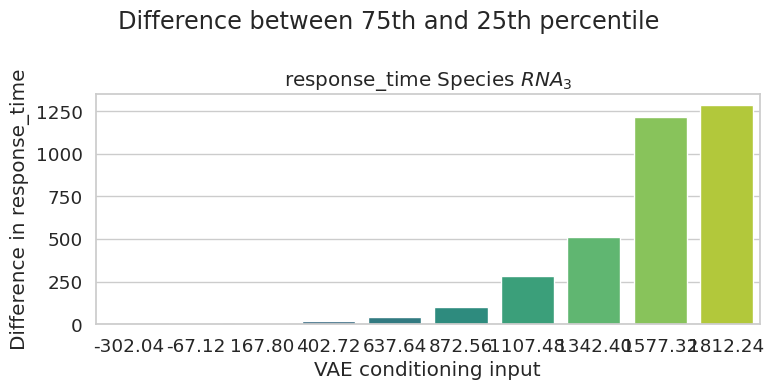

In [26]:
fig, axs = plt.subplots(1, len(config_dataset.objective_col), sharey=True, figsize=(8, 4))
if len(config_dataset.objective_col) == 1:
    axs = [axs]
for i, k in enumerate(config_dataset.objective_col):
    if k not in analytics:
        print(f'The analytic {k} was not simulated in analytics')
        continue
    sns.barplot(pd.DataFrame((diffs_conditional_real_sens[..., -1] - diffs_conditional_real_sens[..., 0])[None, :], columns=[
                f'{ii:.2f}' for ii in sampled_conds_rev[..., i].flatten()]), palette='viridis', ax=axs[i])
    # txt = 'sensitivity' if 'sensitivity' in k else ('adaptation' if 'adaptation' in k else k)
    out_spec_renamed = config_dataset.output_species[0].split('_')[0] + '_' + str(int(config_dataset.output_species[0].split('_')[1]) + 1)
    axs[i].set_title(f'{k} Species ${out_spec_renamed}$')
    axs[i].set_xlabel('VAE conditioning input')
    axs[i].set_ylabel(f'Difference in {k}')
plt.suptitle(f'Difference between 75th and 25th percentile')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'diffs_stds_sens_barplot.png'), dpi=300, transparent=True)


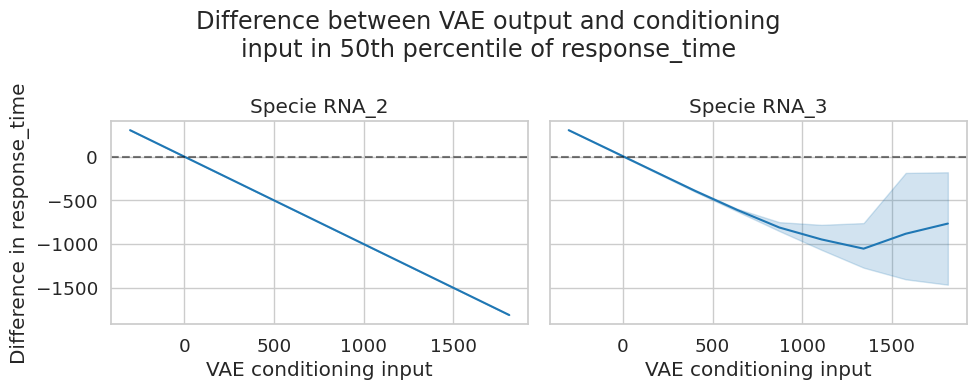

In [27]:
for ik, k in enumerate(config_dataset.objective_col):
    if k not in analytics:
        print(f'The analytic {k} was not simulated in analytics')
        continue
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    fig.subplots_adjust(hspace=0.3, top=0.8)
    for i, output_specie in enumerate(output_species):
        output_idx = all_species.index(output_specie)
        # diffs_conditional_real_sens = jax.vmap(lambda xxx: jnp.percentile(xxx, q=np.array([25, 50, 75])))(
        #     analytics[k][:, output_idx].reshape(n_categories, n_samples // n_categories)) - sampled_conds_rev[:, ik, None]
        diffs_conditional_real_sens = calc_diffs(analytics[k][:, output_idx].reshape(n_categories, n_samples // n_categories), 
                                                 n_categories, sampled_conds_rev[:, ik, None])
        diff_df = pd.DataFrame(np.concatenate([sampled_conds_rev[:, ik, None], diffs_conditional_real_sens], axis=1), columns=['index', '25th', '50th', '75th']).set_index('index')
        diff_df = diff_df.melt(var_name='Percentile', value_name='Difference', ignore_index=False).reset_index().rename(columns={'index': 'Conditioning input'})
        sns.lineplot(diff_df, x='Conditioning input', y='Difference', ax=axs[i])
        axs[i].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        analytic_reshaped = analytics[k][:, output_idx].reshape(n_categories, n_samples // n_categories)
        sampled_conds_expanded = np.ones_like(analytic_reshaped) * sampled_conds_rev[:, ik, None]
        precision, recall, f1 = calc_prompt_adherence(sampled_conds_expanded, analytic_reshaped, 0.1)

        axs[i].set_xlabel('VAE conditioning input')
        axs[i].set_ylabel(f'Difference in {k}')
        out_spec_renamed = output_specie.split('_')[0] + '_' + str(int(output_specie.split('_')[1]))
        axs[i].set_title(f'Specie {out_spec_renamed}') #: recall = {np.nanmean(recall):.2f}')
        # print('Diffs:', diffs_conditional_real_sens[:, 1], np.sum(
        #     np.abs(diffs_conditional_real_sens[:, 1])))
        
    plt.suptitle(
        f'Difference between VAE output and conditioning\ninput in 50th percentile of {k}')
    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, f'diffs_sens_recall_{k}.png'), dpi=300, transparent=True)

# diff_m = np.abs(sampled_conds_expanded - analytic_reshaped).mean(axis=1)
# diff_s = np.abs(sampled_conds_expanded - analytic_reshaped).std(axis=1)
# diff_m, diff_s

### Distance between distributions

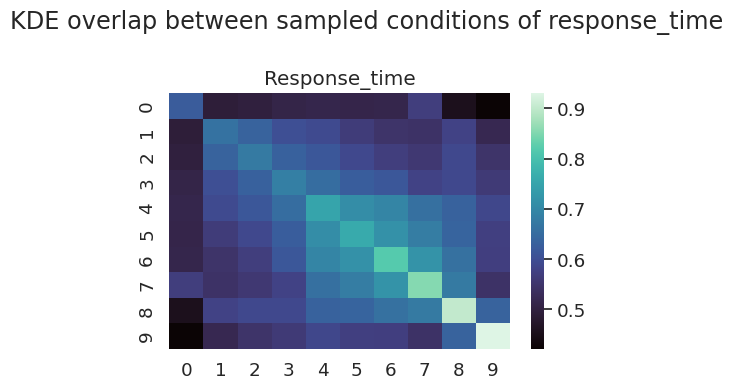

In [28]:
from evoscaper.model.evaluation import (KL_per_dist, hellinger_distance, wasserstein_distance, jensen_shannon_divergence, bhattacharyya_distance,
                                        cross_entropy, total_variation_distance, kolmogorov_smirnov_statistic, area_under_roc_curve, calculate_kde_overlap_core)


def calc_distance(dists, method='hellinger distance'):
    if method == 'kl divergence':
        f = KL_per_dist
    elif method == 'hellinger distance':
        f = hellinger_distance
    elif method == 'wasserstein distance':
        f = wasserstein_distance
    elif method == 'Jensen-Shannon divergence':
        f = jensen_shannon_divergence
    elif method == 'Bhattacharyya distance':
        f = bhattacharyya_distance
    elif method == 'Cross-entropy':
        f = cross_entropy
    elif method == 'Total variation distance':
        f = total_variation_distance
    elif method == 'Kolmogorov-Smirnov statistic':
        f = kolmogorov_smirnov_statistic
    elif method == 'Area Under ROC Curve (AUC)':
        f = area_under_roc_curve
    elif method == 'KDE overlap':
        f = calculate_kde_overlap_core
    else:
        raise ValueError('Unknown method')

    epsilon = 1e-5
    diffs = np.zeros((dists.shape[0], dists.shape[0]))
    dists_norm = np.interp(
        dists, [np.nanmin(dists), np.nanmax(dists)], [epsilon, 1])
    dists_norm = dists_norm / np.nansum(dists_norm, axis=1)[:, None]
    for i in range(dists.shape[0]):
        for j in range(dists.shape[0]):
            # P = dists_norm[i]
            # Q = dists_norm[j]
            # Pn = np.interp(P, [np.nanmin(P), np.nanmax(P)], [epsilon, 1])
            # Pn = Pn / np.sum(Pn)
            # Qn = np.interp(Q, [np.nanmin(Q), np.nanmax(Q)], [epsilon, 1])
            # Qn = Qn / np.sum(Qn)
            div = f(dists_norm[i], dists_norm[j])
            diffs[i, j] = div
    return diffs


# Calculate KL divergence between axis=0 distributions in analytics_reshaped
method_text = 'KDE overlap'
# method_text = 'hellinger distance'
fig, axs = plt.subplots(1, len(config_dataset.objective_col),
                        sharey=True, figsize=(5*len(config_dataset.objective_col), 4))
if len(config_dataset.objective_col) == 1:
    axs = [axs]
for i, k in enumerate(config_dataset.objective_col):
    if k not in analytics:
        print(f'The analytic {k} was not simulated in analytics')
        continue
    analytics_reshaped = analytics[k][:, output_idx].reshape(
        n_categories, n_samples // n_categories)
    # sampled_conds_expanded = np.ones_like(analytic_reshaped) * sampled_conds_rev[:, ik, None]
    # .reshape(n_categories, n_categories)
    distances = np.array(calc_distance(analytics_reshaped, method=method_text))
    w_sampled_cond = np.abs(jax.vmap(lambda x: np.ones((len(x), len(
        x)))*x - (np.ones((len(x), len(x)))*x).T)(sampled_conds.T)).sum(axis=0)

    sns.heatmap(distances, ax=axs[i], cmap='mako')
    # sns.scatterplot(x=sampled_conds_rev[i], y=sampled_conds_rev[i], hue=kl_divergences_s[:, 2] - distances[:, 2], ax=axs[i])
    # Print the KL divergences
    # for i, j, kl_div in distances:
    #     print(f"KL divergence between distribution {i} and {j}: {kl_div}")
    axs[i].set_title(k.capitalize())
    if sampled_conds.shape[-1] == 2:
        axs[i].set_xticklabels(sampled_conds.round(1)[:, 0][::2])
        axs[i].set_yticklabels(sampled_conds.round(1)[:, 1][::2])
        axs[i].set_xlabel(config_dataset.objective_col[0])
        if len(config_dataset.objective_col) == 2:
            axs[i].set_ylabel(config_dataset.objective_col[1])

plt.suptitle(
    f'{method_text} between sampled conditions of {", ".join(config_dataset.objective_col)}')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'distribution_distances.png'),
            dpi=300, transparent=True)

category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
/tmp/ipykernel_1345607/632274811.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sampled_conds_rev.round(1)[..., i], y=distances.mean(axis=1), ax=axs[1+i], palette='viridis')
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO


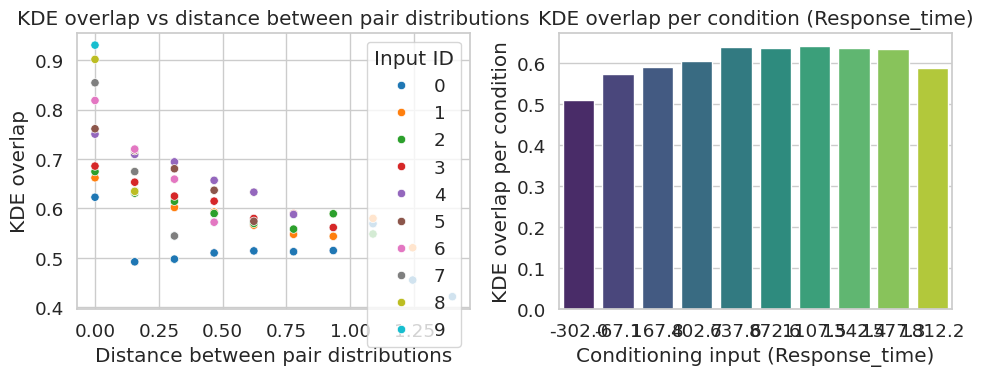

In [29]:
analytics_reshaped = analytics[config_dataset.objective_col[0]][:, output_idx].reshape(
    n_categories, n_samples // n_categories)
distances = np.array(calc_distance(analytics_reshaped, method=method_text))
fig, axs = plt.subplots(1, 1 + len(config_dataset.objective_col), figsize=(5*(len(config_dataset.objective_col) + 1), 4))
sns.scatterplot(x=w_sampled_cond.flatten(), y=distances.flatten(), hue=(np.ones_like(distances) * np.arange(len(distances))).flatten().astype(int), palette='tab10', ax=axs[0]) # sampled_conds[:, 0]).flatten().round(1))
axs[0].legend(title='Input ID')
axs[0].set_xlabel('Distance between pair distributions')
axs[0].set_ylabel(f'{method_text}')
axs[0].set_title(f'{method_text} vs distance between pair distributions')

for i, o in enumerate(config_dataset.objective_col):
    sns.barplot(x=sampled_conds_rev.round(1)[..., i], y=distances.mean(axis=1), ax=axs[1+i], palette='viridis')
    axs[1+i].set_title(f'{method_text} per condition ({o.capitalize()})')
    axs[1+i].set_xlabel(f'Conditioning input ({o.capitalize()})')
    axs[1+i].set_ylabel(f'{method_text} per condition')
    
plt.tight_layout()

In [30]:
if len(config_dataset.objective_col) == 2:
    g = sns.barplot(x=(np.ones_like(distances) * sampled_conds_rev[:, 0]).flatten().round(1),  # [f'{np.round(ii, 1).tolist()}'.replace(',', '\n') for ii in sampled_conds_rev.round(1).tolist()],
                    y=distances.flatten(), #.mean(axis=1),
                    hue=(np.ones_like(distances) * sampled_conds_rev[:, 1]).flatten().round(1), 
                    palette='flare')
    plt.legend(title=config_dataset.objective_col[1])
    plt.xlabel(config_dataset.objective_col[0])
    plt.ylabel(f'{method_text}')
    plt.title(f'{method_text} vs distance between pair distributions')
    sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
    # plt.xticks([f'{np.round(ii, 1).tolist()}'.replace(',', '\n') for ii in sampled_conds_rev.round(1).tolist()[::2]])

In [31]:
def plot_all_distribution_pairs_with_distance():
    for ik, k in enumerate(config_dataset.objective_col):
        if k not in analytics:
            print(f'The analytic {k} was not simulated in analytics')
            continue
        analytics_reshaped = analytics[k][:, output_idx].reshape(n_categories, int(hpos['eval_n_to_sample']) // n_categories)
        distances = np.array(calc_distance(analytics_reshaped, method=method_text))
        fig, axs = plt.subplots(n_categories, n_categories, figsize=(n_categories * 1, n_categories * 1))
        for i in range(n_categories):
            for j in range(n_categories):
                sns.kdeplot(analytics_reshaped[np.array([i, j])].T, ax=axs[i, j], legend=False)
                axs[i, j].set_title(f'{distances[i, j]:.2f}')
                axs[i, j].set_xticks([])
                axs[i, j].set_yticks([])
                axs[i, j].set_ylabel('')
        plt.suptitle(f'{method_text.capitalize()} between sampled conditions of {k}')
        plt.tight_layout(rect=[0, 0, 1, 0.95])

### Recall

In [32]:
sampled_conds.shape, sampled_conds_rev.shape

((10, 1), (10, 1))

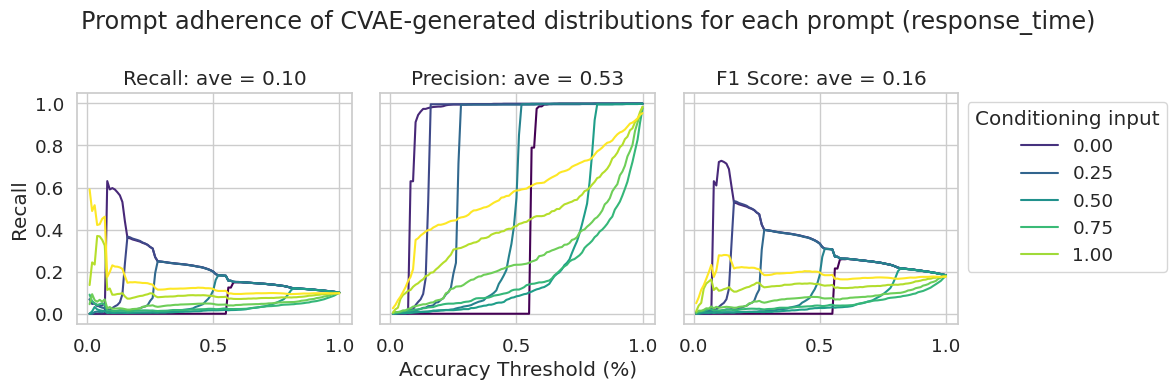

In [33]:
sampled_conds_rev = sampled_conds_rev.round(3)


for i, k in enumerate(config_dataset.objective_col):

    perc_recall = np.arange(0.01, 1.01, 0.01).astype(np.float32)
    analytics_reshaped = analytics[k][:, output_idx].reshape(n_categories, n_samples // n_categories)
    sampled_conds_expanded = np.ones_like(analytic_reshaped) * sampled_conds_rev[:, ik, None]
    precision, recall, f1 = jax.vmap(partial(calc_prompt_adherence, pred=sampled_conds_expanded, real=analytics_reshaped))(perc_recall=perc_recall)

    fig, axs = plt.subplots(1, 3, sharey=True, figsize=(4*3, 4))
    df_recall = pd.DataFrame(data=recall.T, columns=perc_recall, index=sampled_conds_rev[:, ik]).melt(var_name='Accuracy Threshold (%)', value_name='Recall', ignore_index=False).reset_index().rename(columns={'index': 'Conditioning input'})
    sns.lineplot(df_recall, x='Accuracy Threshold (%)', y='Recall', hue='Conditioning input', palette='viridis', ax=axs[0], legend=False)
    axs[0].set_title(f'Recall: ave = {np.nanmean(recall):.2f}')
    axs[0].set_xlabel('')

    df_precision = pd.DataFrame(data=precision.T, columns=perc_recall, index=sampled_conds_rev[:, ik]).melt(var_name='Accuracy Threshold (%)', value_name='Precision', ignore_index=False).reset_index().rename(columns={'index': 'Conditioning input'})
    sns.lineplot(df_precision, x='Accuracy Threshold (%)', y='Precision', hue='Conditioning input', palette='viridis', ax=axs[1], legend=False)
    axs[1].set_title(f'Precision: ave = {np.nanmean(precision):.2f}')

    df_f1 = pd.DataFrame(data=f1.T, columns=perc_recall, index=sampled_conds[:, ik].round(2)).melt(var_name='Accuracy Threshold (%)', value_name='F1', ignore_index=False).reset_index().rename(columns={'index': 'Conditioning input'})
    g = sns.lineplot(df_f1, x='Accuracy Threshold (%)', y='F1', hue='Conditioning input', palette='viridis', ax=axs[2])
    sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
    axs[2].set_title(f'F1 Score: ave = {np.nanmean(f1):.2f}')
    axs[2].set_xlabel('')

    plt.suptitle(f'Prompt adherence of CVAE-generated distributions for each prompt ({k})')
    plt.tight_layout()

    plt.savefig(os.path.join(top_write_dir, f'recall_f1_{k}.png'), dpi=300, transparent=True)



In [34]:
# for k in config_dataset.objective_col:
#     plt.figure()
#     output_idx = all_species.index(
#         config_dataset.output_species[0])
#     diffs_conditional_real_sens = jax.vmap(lambda xxx: jnp.percentile(xxx, q=np.array([25, 50, 75])))(
#         analytics[k][:, output_idx].reshape(n_categories, int(hpos['eval_n_to_sample']) // n_categories)) - sampled_conds[:, None]
#     plot_diffs(diffs_conditional_real_sens, sampled_conds, plt.subplot(1, 1, 1),
#                palette=sns.cubehelix_palette(start=3, rot=0, dark=0.6, light=.6, reverse=False, as_cmap=False, n_colors=n_categories))
#     #  palette=sns.cubehelix_palette(start=1, rot=1.5, dark=0.3, light=.7, reverse=False, as_cmap=False, n_colors=10))
#     plt.title(
#         f'Difference between target {k} and\n50th percentile of actual: Species {config_dataset.output_species[0]}')

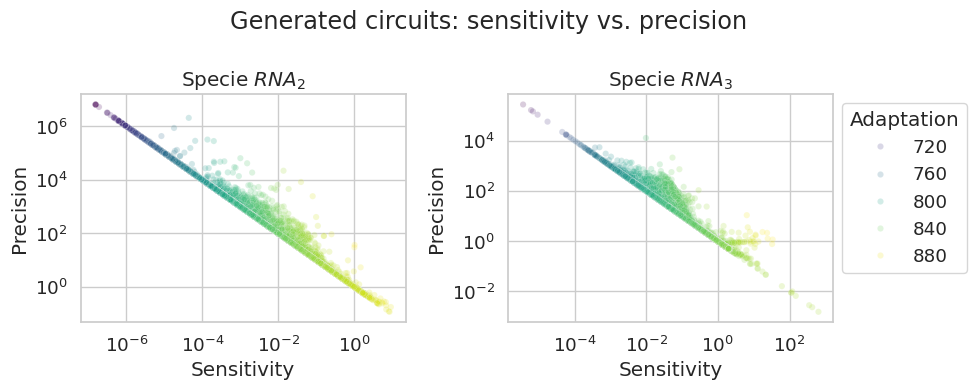

In [35]:
fig = plt.figure(figsize=(10, 4))

# category_array = np.array(sorted(y_datanormaliser.metadata[config_dataset.objective_col[0]]["category_map"].values())).repeat(
#     len(analytics['sensitivity'])//len(y_datanormaliser.metadata[config_dataset.objective_col[0]]["category_map"]))
# category_array = sampled_cond.reshape(np.prod(sampled_cond.shape[:-1]), -1)
for i, output_specie in enumerate(output_species):
    output_idx = all_species.index(output_specie)
    d = pd.DataFrame()
    d['Sensitivity'] = analytics['sensitivity'][:, output_idx]
    d['Precision'] = analytics['precision'][:, output_idx]
    d['Adaptation'] = analytics['adaptation'][:, output_idx]
    # d['VAE conditioning input'] = category_array
    d['VAE conditioning input'] = np.array([', '.join(map(str, row)) for row in category_array])
    ax = plt.subplot(1,2,i+1)
    g = sns.scatterplot(d, x='Sensitivity', y='Precision', alpha=0.2, hue='Adaptation', palette='viridis', s=20, legend=i == len(output_species)-1)
    if i == len(output_species)-1:
        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Specie ${output_specie}$')
plt.suptitle('Generated circuits: sensitivity vs. precision')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'scatter_sp_adapt.png'), dpi=300, transparent=True)

In [36]:
sampled_cond.reshape(-1, sampled_cond.shape[-1]).shape, c.shape

((10000, 1), (10000, 1))

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 640x480 with 0 Axes>

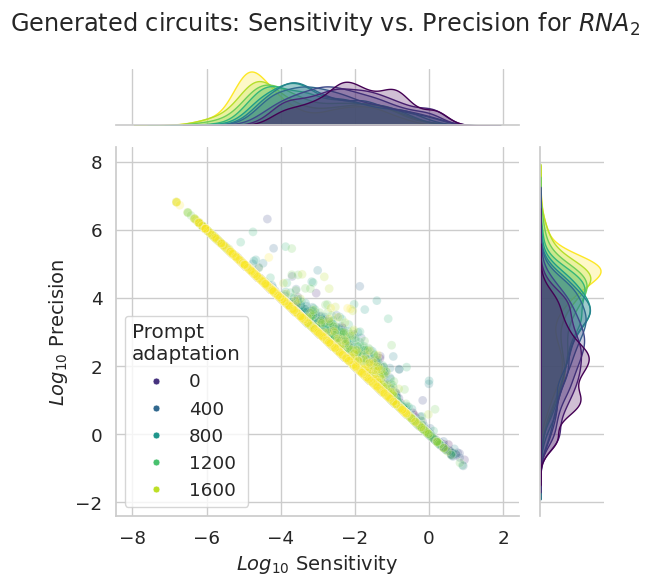

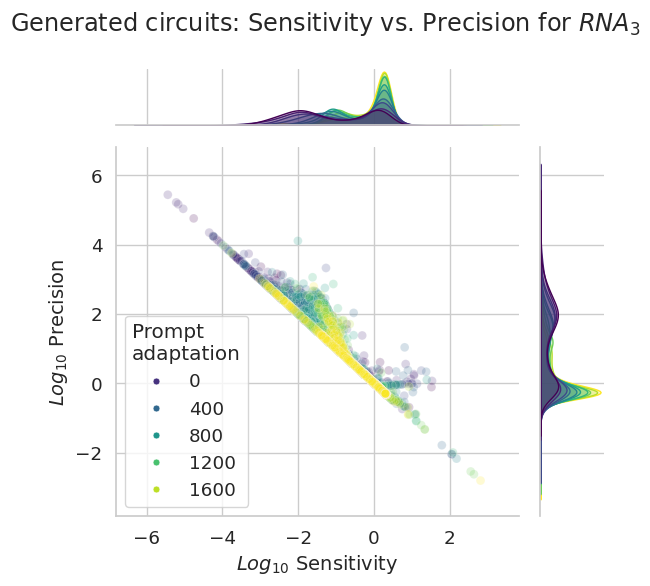

In [37]:
# fig = plt.figure(figsize=(13, 4))
if len(config_dataset.objective_col) <= 2:
    plt.subplots_adjust(top=0.8)

    for i, output_specie in enumerate(output_species):
        output_idx = all_species.index(output_specie)
        d = pd.DataFrame()
        d['Sensitivity'] = analytics['sensitivity'][:, output_idx]
        d['Precision'] = analytics['precision'][:, output_idx]
        d['Adaptation'] = analytics['adaptation'][:, output_idx]
        d['Log10 Sensitivity'] = np.log10(d['Sensitivity'])
        d['Log10 Precision'] = np.log10(d['Precision'])
        # d['Conditioning input'] = np.array([', '.join(map(str, row)) for row in sampled_cond.reshape(-1, sampled_cond.shape[-1]).round(2)])
        d['Prompt'] = c.round(0).astype(int)
        # ax = plt.subplot(1,2,i+1)
        # sns.jointplot(d, x='Log10 Sensitivity', y='Log10 Precision', alpha=0.2, hue='Adaptation', palette='viridis', s=20)
        g = sns.jointplot(d, x='Log10 Sensitivity', y='Log10 Precision', alpha=0.2, hue='Prompt', palette='viridis', s=40)
        # sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(1.3, 1))
        # plt.title(f'Specie {output_specie}')
        
        for line in g.ax_joint.legend().get_lines():
            line.set(alpha=1.0, markersize=5)
        g.ax_joint.legend_.set_title('Prompt\nadaptation')
        
        plt.xlabel('$Log_{{10}}$ Sensitivity', fontsize=14)
        plt.ylabel('$Log_{{10}}$ Precision', fontsize=14)
        plt.suptitle(f'Generated circuits: Sensitivity vs. Precision for ${output_specie}$')
        plt.tight_layout()
        # plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(os.path.join(top_write_dir, f'joint_sp_sens_{i}.png'), dpi=300, transparent=True)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 640x480 with 0 Axes>

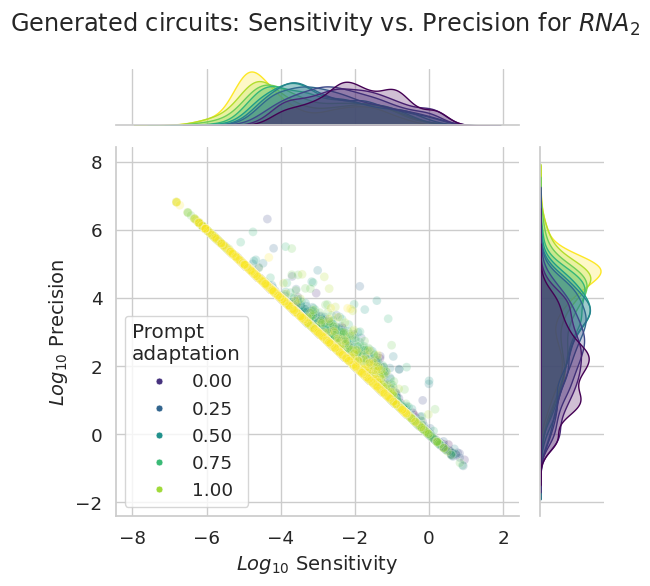

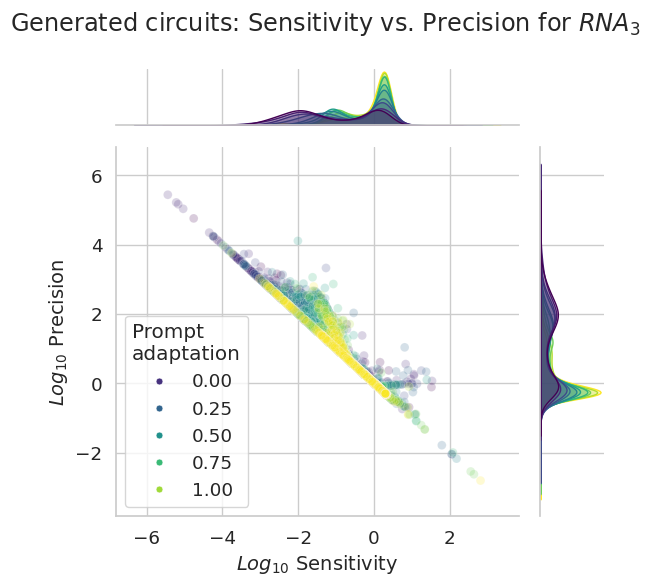

In [38]:
if len(config_dataset.objective_col) <= 2:
    plt.subplots_adjust(top=0.8)

    for i, output_specie in enumerate(output_species):
        output_idx = all_species.index(output_specie)
        d = pd.DataFrame()
        d['Sensitivity'] = analytics['sensitivity'][:, output_idx]
        d['Precision'] = analytics['precision'][:, output_idx]
        d['Adaptation'] = analytics['adaptation'][:, output_idx]
        d['Log10 Sensitivity'] = np.log10(d['Sensitivity'])
        d['Log10 Precision'] = np.log10(d['Precision'])
        # d['Prompt'] = np.array([', '.join(map(str, row)) for row in sampled_cond.reshape(-1, sampled_cond.shape[-1]).round(2)])
        d['Prompt'] = sampled_cond.reshape(-1, sampled_cond.shape[-1]).round(2)
        g = sns.jointplot(d, x='Log10 Sensitivity', y='Log10 Precision', alpha=0.2, hue='Prompt', palette='viridis', s=40)
        # sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(1.3, 1))
        
        for line in g.ax_joint.legend().get_lines():
            line.set(alpha=1.0, markersize=5)
        g.ax_joint.legend_.set_title('Prompt\nadaptation')
        
        plt.xlabel('$Log_{{10}}$ Sensitivity', fontsize=14)
        plt.ylabel('$Log_{{10}}$ Precision', fontsize=14)
        plt.suptitle(f'Generated circuits: Sensitivity vs. Precision for ${output_specie}$')
        plt.tight_layout()
        # plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(os.path.join(top_write_dir, f'joint_sp_sens_{i}b.png'), dpi=300, transparent=True)

In [39]:
# # fig = plt.figure(figsize=(13, 4))
# plt.subplots_adjust(top=0.8)

# for i, output_specie in enumerate(output_species):
#     output_idx = all_species.index(output_specie)
#     d = pd.DataFrame()
#     d['Sensitivity'] = analytics['sensitivity'][:, output_idx]
#     d['Precision'] = analytics['precision'][:, output_idx]
#     d['Adaptation'] = analytics['adaptation'][:, output_idx]
#     d['Adaptation Bin'] = pd.cut(d['Adaptation'], bins=10).apply(lambda x: x.mid)
#     d['Log10 Sensitivity'] = np.log10(d['Sensitivity'])
#     d['Log10 Precision'] = np.log10(d['Precision'])
#     d['VAE conditioning input'] = np.array([', '.join(map(str, row)) for row in category_array.round(2)])
#     # ax = plt.subplot(1,2,i+1)
#     sns.jointplot(d, x='Log10 Sensitivity', y='Log10 Precision', alpha=0.2, hue='Adaptation Bin', palette='viridis', s=20)
#     # plt.title(f'Specie {output_specie}')
#     plt.suptitle(f'Generated circuits: sensitivity vs. precision - Specie {output_specie}')
#     # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#     plt.tight_layout()
#     plt.savefig(os.path.join(top_write_dir, f'joint_sp_adapt_{i}.png'), dpi=300, transparent=True)

# Quick UMAP

In [40]:
from evoscaper.model.vae import sample_z
from evoscaper.utils.math import bin_array
import itertools
import umap

use_h = False
n_show = 5000
random_state = 0
output_idx = -1
rng_key = jax.random.PRNGKey(random_state)  # Initialize a PRNG key with a seed
labels_chosen_a = ['adaptation', 'Log sensitivity', 'Log precision']
method = 'UMAP'


def get_latent(params, rng, encoder, h2mu, h2logvar, fake_circuits, sampled_cond, use_h):
    h_all = encoder(params, rng, np.concatenate([fake_circuits, sampled_cond], axis=-1))
    h_all = h_all.reshape(np.prod(h_all.shape[:-1]), -1)
    mu = h2mu(params, rng, h_all)
    logvar = h2logvar(params, rng, h_all)
    z_all = sample_z(mu, logvar, rng, deterministic=True)
    if use_h:
        z_all = h_all
    return z_all


def get_idxs_show(rng_key, n_show, cond_rev_all, cond_binned, cond_unique):
    
    if n_show < len(cond_rev_all):
        idxs_show = []
        for c in cond_unique:
            idxs_show.extend(np.where((cond_binned != c).sum(axis=-1) == 0)[0][:np.max([n_show//len(cond_unique), 5])])
        idxs_show = np.array(idxs_show).astype(int)
        if len(idxs_show) > n_show:
            idxs_show = jax.random.choice(rng_key, np.arange(len(cond_rev_all)), (n_show,), replace=False)
    else:
        idxs_show = jax.random.choice(rng_key, np.arange(len(cond_rev_all)), (n_show,), replace=False).astype(int)
    return idxs_show


def get_cond_bin_uniq(cond_rev_all):
    cond_binned = cond_rev_all
    if not hpos.loc['prep_y_categorical']:
        cond_binned = bin_array(
            cond_rev_all, num_bins=n_categories)[0].round(1)
        if cond_binned.ndim == 1:
            cond_binned = cond_binned[:, None]
    cond_unique = [np.unique(cond_binned[..., i]) for i in range(cond_binned.shape[-1])]
    cond_unique = np.array(list(itertools.product(*cond_unique)))
    return cond_binned, cond_unique


analytics['sensitivity'] = np.where(
    analytics['sensitivity'] == 0, np.nan, analytics['sensitivity'])
analytics['Log sensitivity'] = np.log10(analytics['sensitivity'])
analytics['adaptation'] = calculate_adaptation(
    analytics['sensitivity'], analytics['precision'], alpha=2)

cond_rev_all = np.concatenate([np.array(analytics[k])[:, output_idx, None] for k in labels_chosen_a], axis=-1)
# cond_rev_all = cond_rev_all.reshape(n_categories, n_samples // n_categories, *cond_rev_all.shape[1:])
x_rev_all = x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(fake_circuits).reshape(-1, fake_circuits.shape[-1])

cond_binned, cond_unique = get_cond_bin_uniq(cond_rev_all)
x_bin = bin_array(fake_circuits, num_bins=hpos.loc['prep_x_categorical_n_bins'])[0].reshape(-1, fake_circuits.shape[-1])

embeddings = get_latent(params, rng_key, encoder, h2mu, h2logvar, fake_circuits, sampled_cond, use_h)


idxs_show = get_idxs_show(rng_key, n_show, cond_rev_all, cond_binned, cond_unique)
if len(np.where(np.isnan(embeddings))[0]):
    bad_idx = np.where(np.isnan(embeddings))[0]
    idxs_show = np.setdiff1d(idxs_show, bad_idx)
    
input_species = [format_with_subscript(i) for i in data['sample_name'].dropna().unique()]

n_species = 3
labels_x = sorted([r'$k_{' + str(i) + str(j) + '}$' for i, j in sorted(set([tuple(sorted(i)) for i in itertools.product(np.arange(n_species) + 1, np.arange(n_species) + 1)]))])
# labels_x = list(itertools.product(input_species, input_species))
# labels_x = sorted(set(tuple(sorted(labels_x[i])) for i in range(len(labels_x))))

### GPLVM

### UMAP

In [41]:
method = 'UMAP'
reducer_umap = umap.UMAP(n_neighbors=100, n_components=2, random_state=random_state,
                         metric='euclidean', n_epochs=2000, learning_rate=0.1, init='spectral')
umap_result = reducer_umap.fit_transform(embeddings[idxs_show])



/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


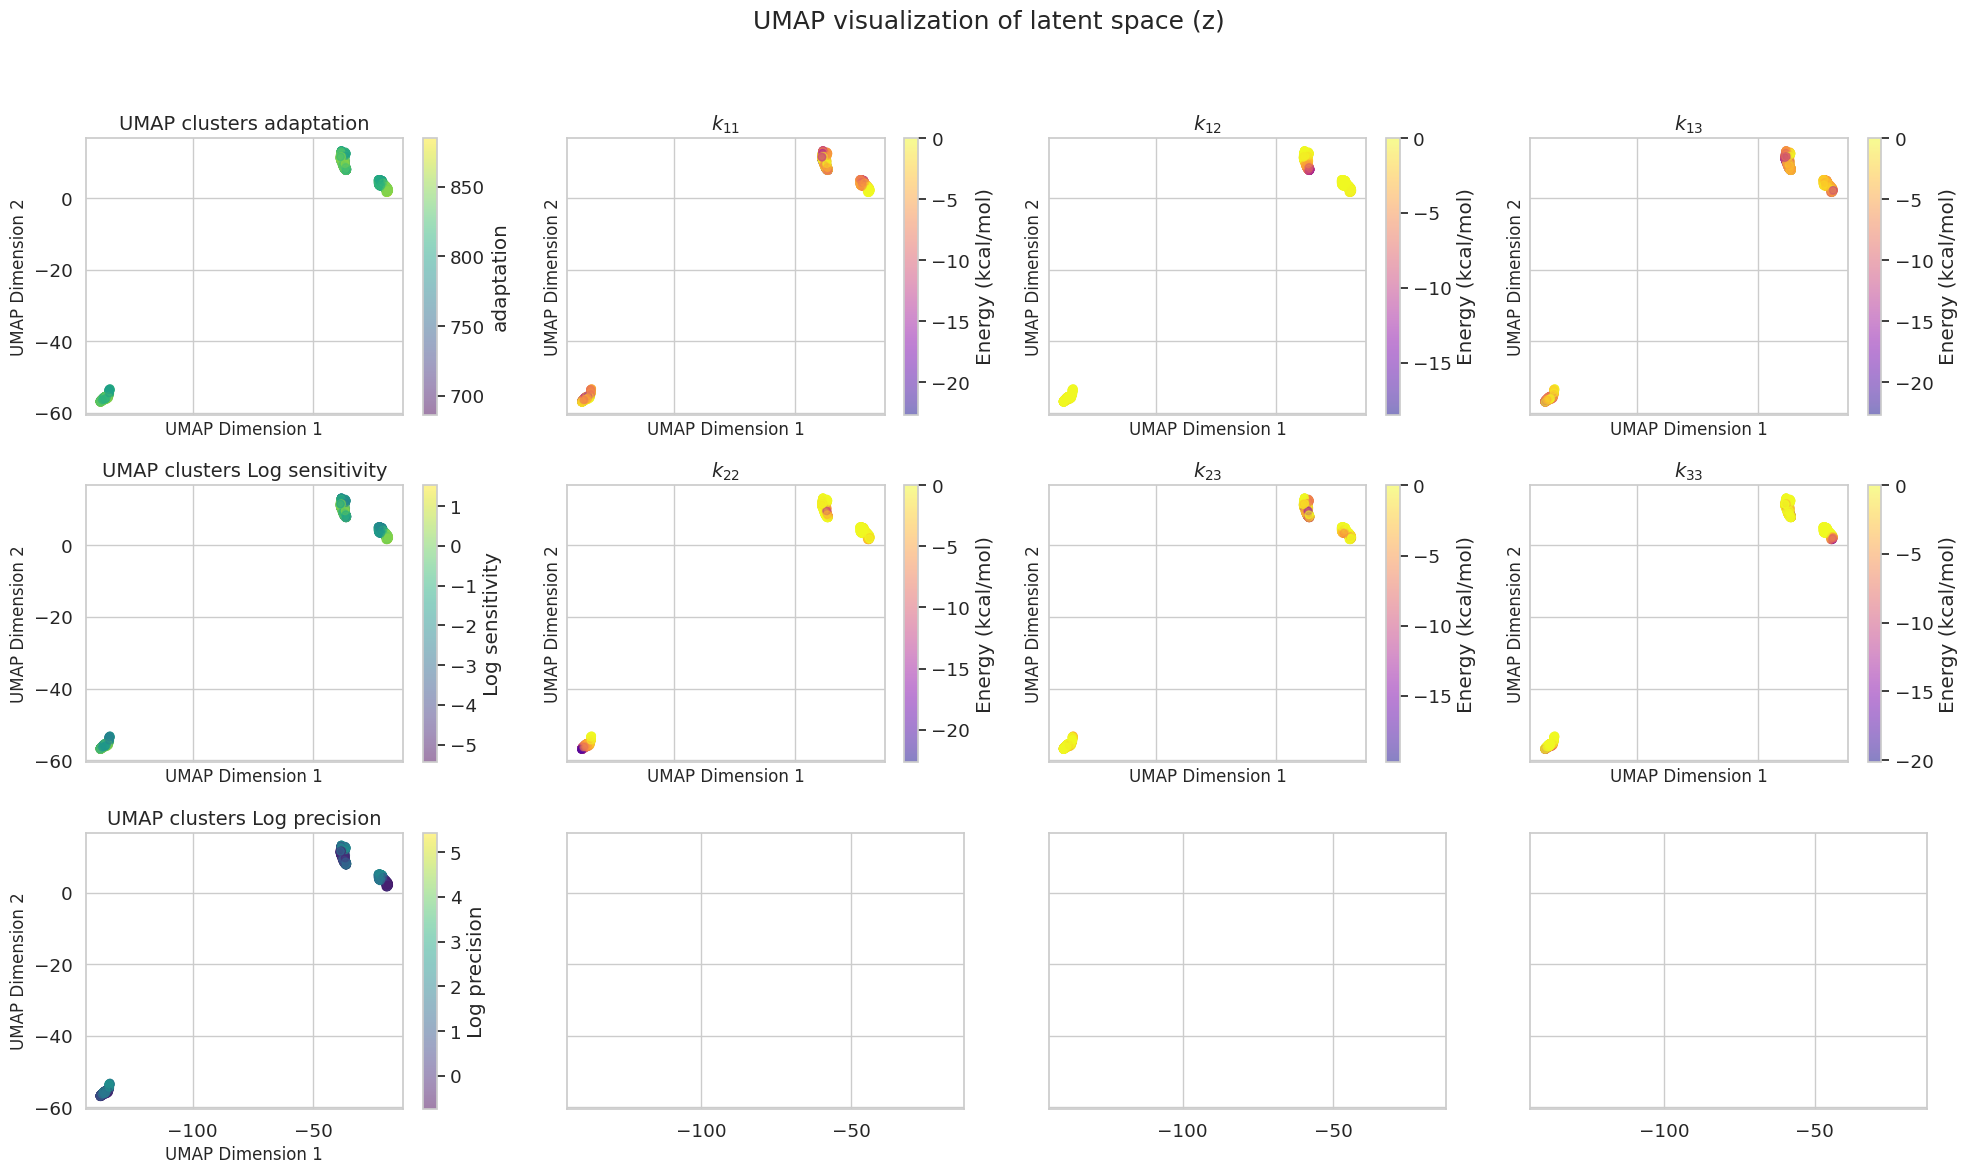

In [42]:
visualize_dimred_2d_custom_labels(umap_result, cond_rev_all[idxs_show], fake_circuits.reshape(-1, fake_circuits.shape[-1])[idxs_show],
                                  labels_cond=labels_chosen_a,
                                  labels_x=labels_x, method=method, save_path=os.path.join(top_write_dir, 'umap_dimred.png'), s=30)

In [43]:
idxs_show2 = jax.random.choice(rng_key, np.arange(
    len(cond_rev_all)), (n_show,), replace=False).astype(int)
if len(np.where(np.isnan(embeddings))[0]):
    bad_idx = np.where(np.isnan(embeddings))[0]
    idxs_show2 = np.setdiff1d(idxs_show2, bad_idx)
umap_result2 = reducer_umap.fit_transform(embeddings[idxs_show2])

In [44]:
stop
visualize_dimred_2d_custom_labels(umap_result2, sampled_cond.flatten()[idxs_show2][:, None], 
                                  fake_circuits.reshape(-1, fake_circuits.shape[-1])[idxs_show2],
                                  labels_cond=config_dataset.objective_col,
                                  labels_x=labels_x, method=method, save_path=os.path.join(top_write_dir, 'umap_objective.png'), sort=False)

NameError: name 'stop' is not defined

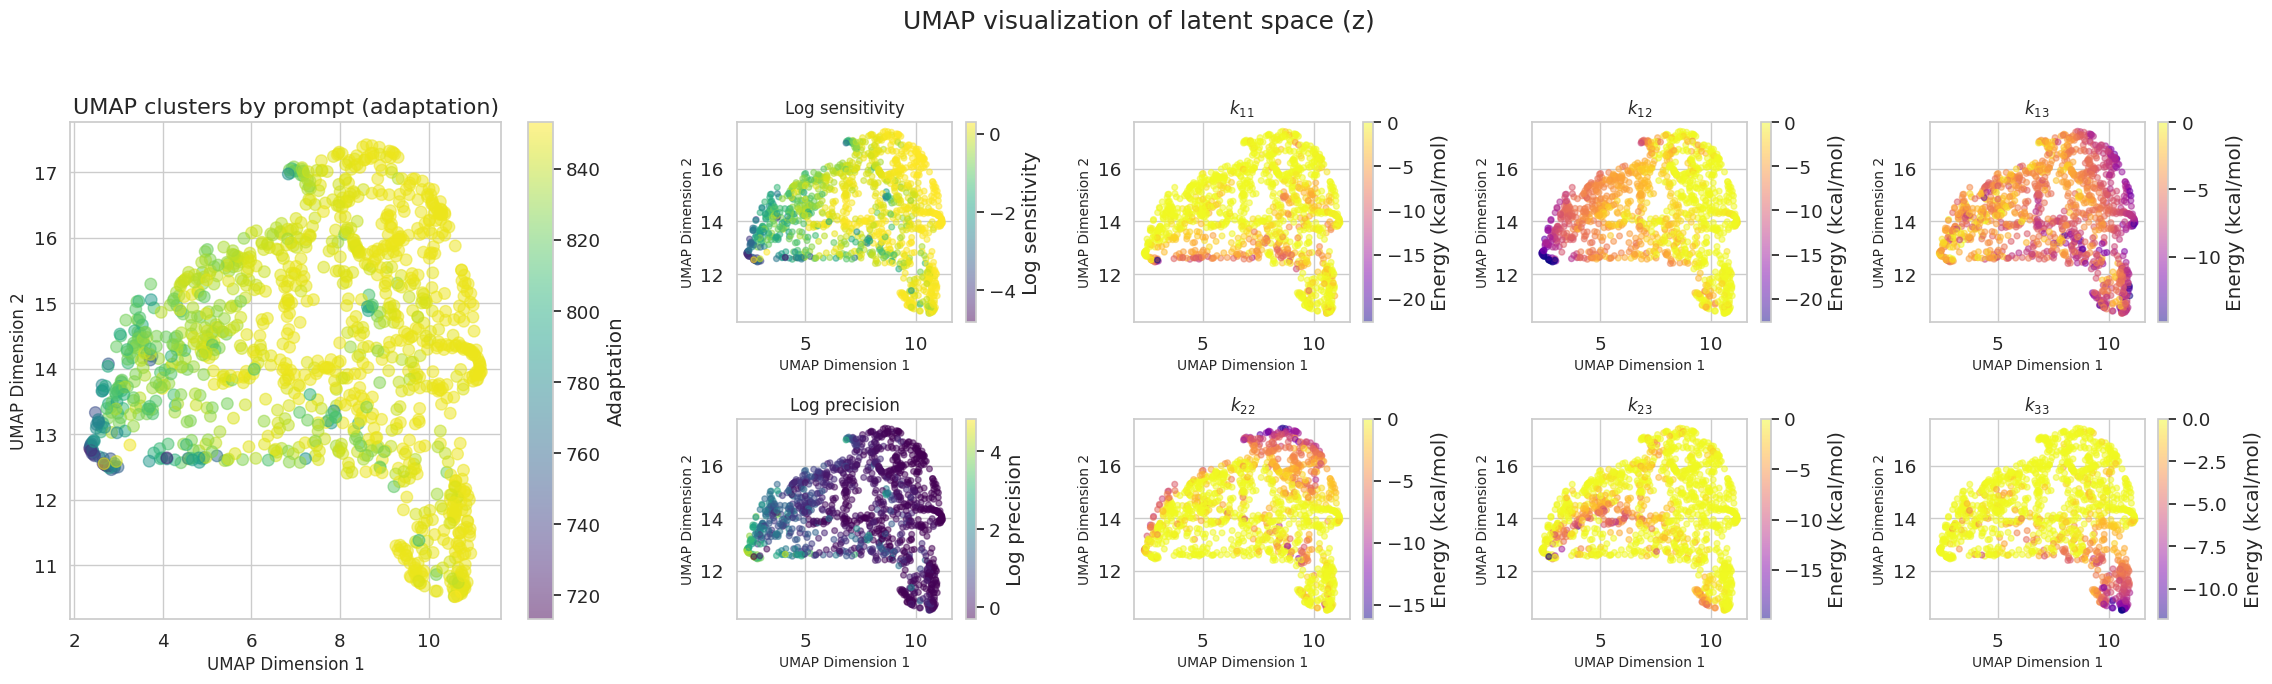

In [ ]:
visualize_dimred_adapt_sp(umap_result, cond_rev_all[idxs_show], fake_circuits.reshape(-1, fake_circuits.shape[-1])[idxs_show],
                          labels_cond=labels_chosen_a,
                          labels_x=labels_x, method=method, save_path=os.path.join(top_write_dir, 'umap_dimred_big.png'), s=70, sort=False)

In [ ]:
sampled_cond.shape, cond_rev_all.shape, x_bin.shape


((2, 5000, 1), (10000, 3), (10000, 6))

In [ ]:
# data_test = pd.read_json(os.path.join('data', 'simulate_circuits', '2025_02_11__13_56_51', 'tabulated_mutation_info.json'))
# data_test = data_test[data_test['sample_name'] == 'RNA_2']
# data_test = data_test[np.isfinite(data_test['sensitivity']) & np.isfinite(data_test['precision'])]

# x_test = data_test[x_cols].values
# cond_test = data_test[config_dataset.objective_col].values


In [ ]:
embeddings_og = get_latent(params, rng_key, encoder, h2mu, h2logvar, x, cond, use_h)

cond_rev_all_og = np.concatenate([y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(
    cond[..., i], col=c).flatten() for i, c in enumerate(config_dataset.objective_col)]).reshape(np.prod(cond.shape[:-1]), -1).squeeze()
x_rev_all_og = x_datanormaliser.create_chain_preprocessor_inverse(
        x_methods_preprocessing)(x).reshape(-1, x.shape[-1]).squeeze()


cond_binned_og, cond_unique_og = get_cond_bin_uniq(cond_rev_all_og)
n_show_og = int(1e4)
idxs_show_og = get_idxs_show(rng_key, n_show_og, cond_rev_all_og, cond_binned_og, cond_unique_og)
if len(np.where(np.isnan(embeddings_og))[0]):
    bad_idx = np.where(np.isnan(embeddings_og))[0]
    idxs_show_og = np.setdiff1d(idxs_show_og, bad_idx)
idxs_show_og.shape


(5006,)

In [ ]:
umap_result_og = reducer_umap.fit_transform(embeddings_og[idxs_show_og])


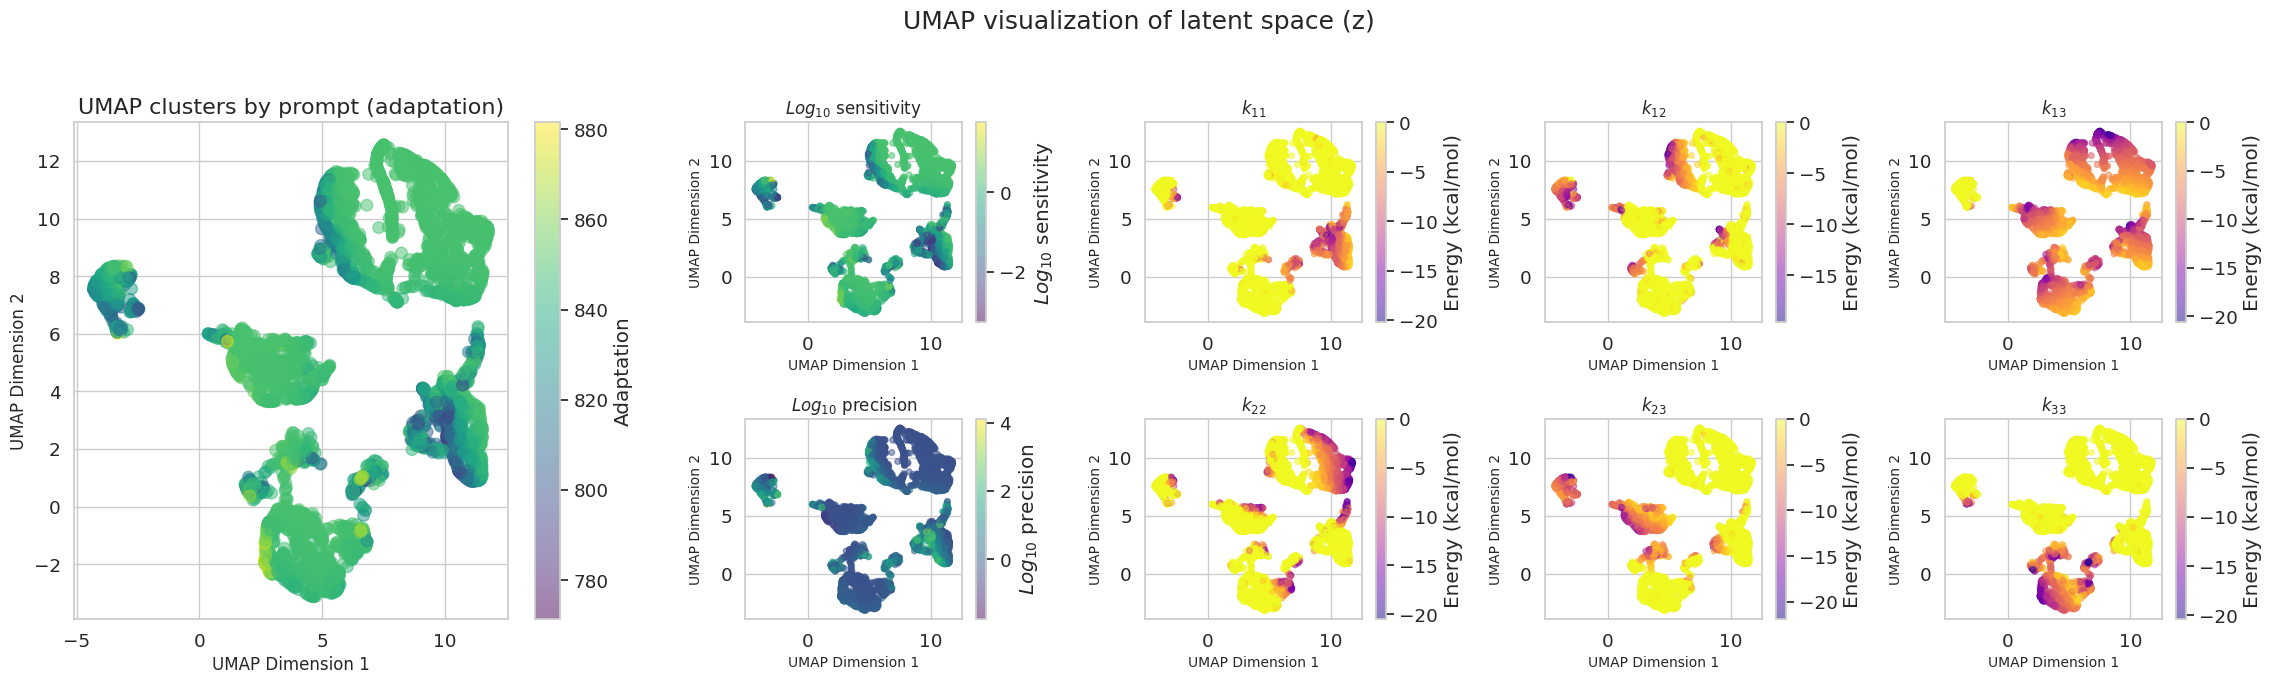

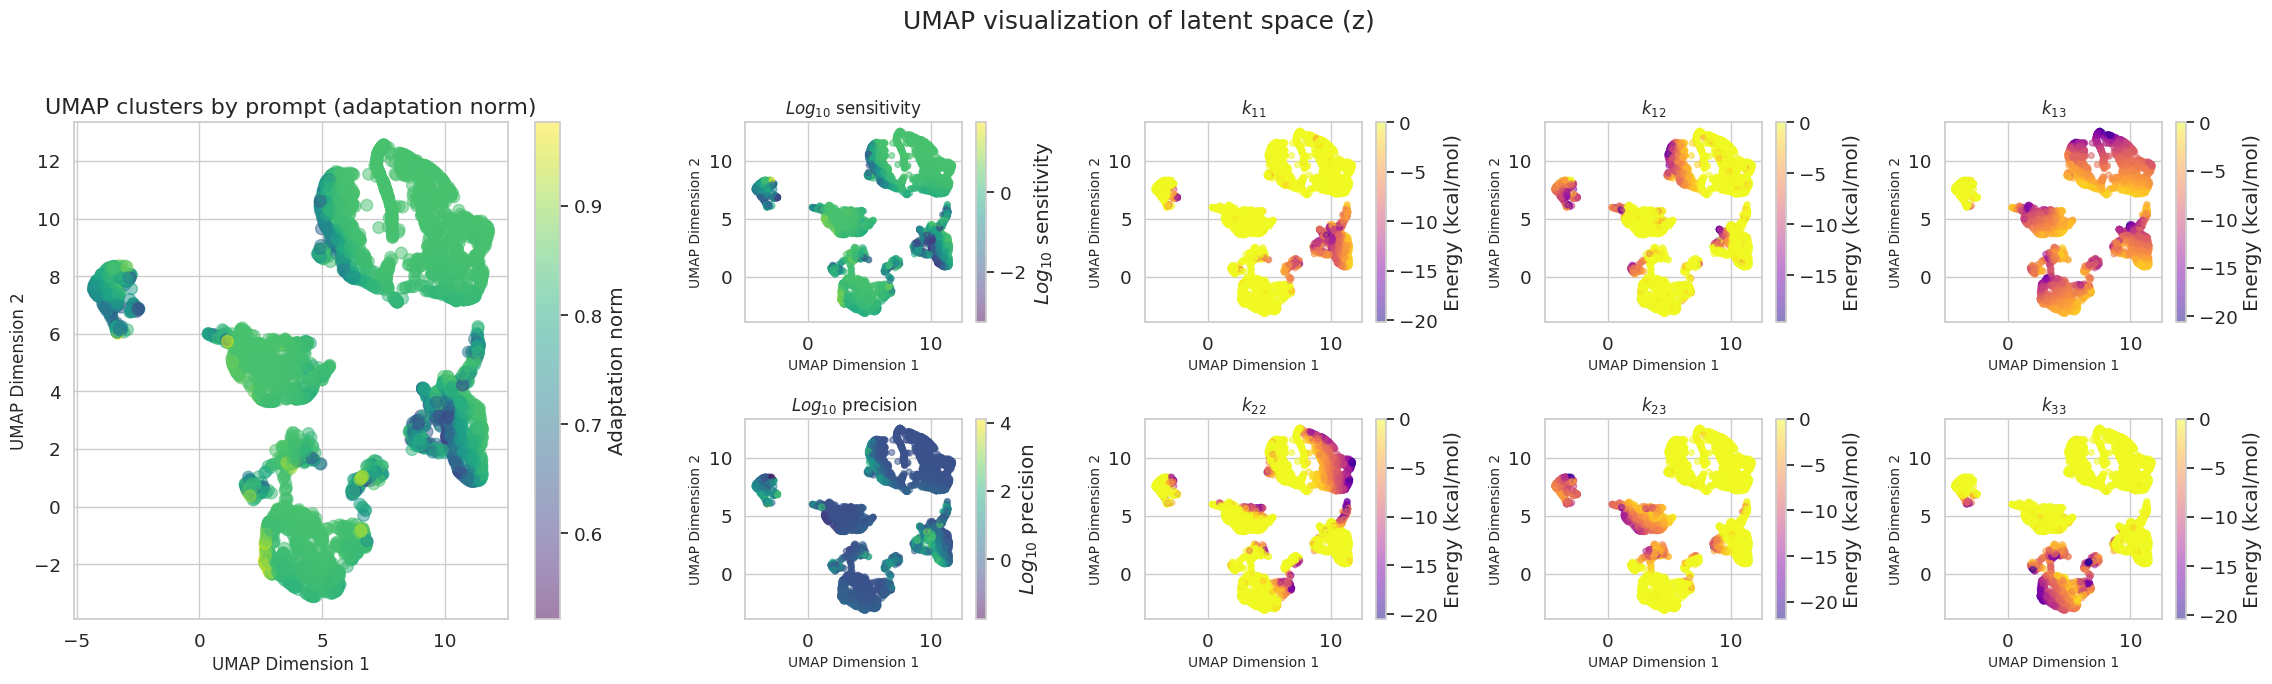

In [ ]:
labels_cond = [c.replace('Log', r'$Log_{10}$') for c in labels_chosen_a]

visualize_dimred_adapt_sp(umap_result_og, df[labels_chosen_a].values[idxs_show_og], np.array(x_rev_all_og[idxs_show_og]),
                          labels_cond=labels_cond,
                          labels_x=labels_x, method=method, save_path=os.path.join(top_write_dir, 'umap_og_big.png'), s=70, sort=False, sort_random=True)

labels_chosen_b = ['adaptation norm', 'Log sensitivity', 'Log precision']
labels_cond = [c.replace('Log', r'$Log_{10}$') for c in labels_chosen_b]
df['adaptation norm'] = scale_norm(df['adaptation'].values, key='adaptation', data=data, vmin=0, vmax=1)
visualize_dimred_adapt_sp(umap_result_og, df[labels_chosen_b].values[idxs_show_og], np.array(x_rev_all_og[idxs_show_og]),
                          labels_cond=labels_cond,
                          labels_x=labels_x, method=method, save_path=os.path.join(top_write_dir, 'umap_og_big_norm.png'), s=70, sort=False, sort_random=True)

### Plot UMAP time-series

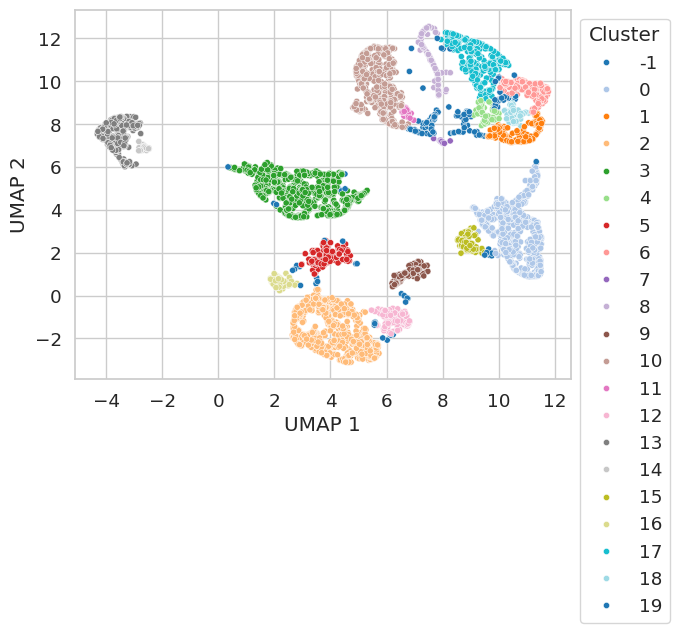

In [ ]:
from common import cluster_parameter_groups

umap_result_df = pd.DataFrame(umap_result_og, columns=['UMAP 1', 'UMAP 2'])
umap_result_df = cluster_parameter_groups(umap_result_df,
                                          method='DBSCAN',
                                          eps=0.34,
                                          # method='KMeans',
                                          # n_true_clusters=5,
                                          min_cluster_size=60,
                                          min_samples=25) #.rename(columns={'Cluster': 'Cluster Alt'})
# umap_result_df['Cluster'] = np.nan

# umap_result_df.loc[(umap_result_df['UMAP 1'] < 6) & (umap_result_df['UMAP 2'] < 4.5), 'Cluster'] = 'Cluster 1'
# umap_result_df.loc[(umap_result_df['UMAP 1'] > 6) & (umap_result_df['UMAP 1'] < 9)
#                    & (umap_result_df['UMAP 2'] < 4.5) & (umap_result_df['UMAP 2'] > 3), 'Cluster'] = 'Cluster 2'
# umap_result_df.loc[(umap_result_df['UMAP 1'] > 5) & (umap_result_df['UMAP 1'] < 6) 
#                    & (umap_result_df['UMAP 2'] > 4.5) & (umap_result_df['UMAP 2'] < 7), 'Cluster'] = 'Cluster 3'
# umap_result_df.loc[(umap_result_df['UMAP 1'] > 10) & (umap_result_df['UMAP 2'] < 4.5), 'Cluster'] = 'Cluster 4'
# # umap_result_df.loc[(umap_result_df['UMAP 1'] > 10) & (umap_result_df['UMAP 2'] < 2), 'Cluster'] = 'Cluster 5'
# umap_result_df.loc[(umap_result_df['UMAP 2'] > 7), 'Cluster'] = 'Cluster 5'

labels_to_include = labels_chosen_a + ['overshoot', 'overshoot/initial']
idxs_show_curr = idxs_show_og # idxs_show2 # 
source_frame = df # analytics # 
# umap_result_df[labels_to_include] = df[labels_to_include].values[idxs_show_og]
for k in labels_to_include:
    v = np.array(source_frame[k])[idxs_show_curr]
    umap_result_df[k] = v if v.ndim == 1 else v[:, output_idx]
umap_result_df['Index og'] = idxs_show_curr

# fig, axs = plt.subplots(1, 2, figsize=(12, 5))
g = sns.scatterplot(umap_result_df, x='UMAP 1', y='UMAP 2', hue='Cluster', palette='tab20', s=20) #, ax=axs[0])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
# g = sns.scatterplot(umap_result_df, x='UMAP 1', y='UMAP 2', hue='adaptation', palette='viridis', s=20, ax=axs[1])
# sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
# plt.tight_layout()

In [ ]:
sort_by = 'overshoot/initial'
sort_by = 'adaptation'
# chosen_clusters = [12, 3, 0, 10, 6] # umap_result_df['Cluster'].unique()  # n_show = 2e4
# chosen_clusters = [12, 6, 11, 7, 0] # umap_result_df['Cluster'].unique()
# chosen_clusters = [13, 3, 0, 6, 7] # umap_result_df['Cluster'].unique()
# chosen_clusters = [13, 3, 2, 9, 7] # umap_result_df['Cluster'].unique()  # hpo 112, 5e3
# chosen_clusters = [2, 1, 4, 0, 6] # umap_result_df['Cluster'].unique()  # hpo 56, 1e4
# chosen_clusters = [1, 0, 8, 2, 3] # umap_result_df['Cluster'].unique()  # hpo 14, 1e4
# chosen_clusters = [0, 1, 2, 3, 4] # umap_result_df['Cluster'].unique()  # hpo 112, umap2
# chosen_clusters = [13, 7, 2, 0, 8] # umap_result_df['Cluster'].unique()  # hpo 112, 1e4, eps=0.4
chosen_clusters = [14, 15, 2, 10, 7] # umap_result_df['Cluster'].unique()  # hpo 112, 1e4, eps=0.34
idxs_adapt = np.concatenate([umap_result_df[umap_result_df['Cluster'] == i].sort_values(
    by=sort_by, ascending=False)['Index og'].values[:1] for i in chosen_clusters])
idxs_adapt[4] = umap_result_df[umap_result_df['Cluster'] == chosen_clusters[4]].sort_values(
    by=sort_by, ascending=False)['Index og'].values[15]
# idxs_adapt = np.concatenate([idxs_adapt, umap_result_df[umap_result_df['Cluster'] == chosen_clusters[4]].sort_values(
#     by=sort_by, ascending=False)['Index og'].values[:15]])

umap_result_df['Selected'] = False
umap_result_df.loc[umap_result_df['Index og'].isin(
    idxs_adapt), 'Selected'] = True

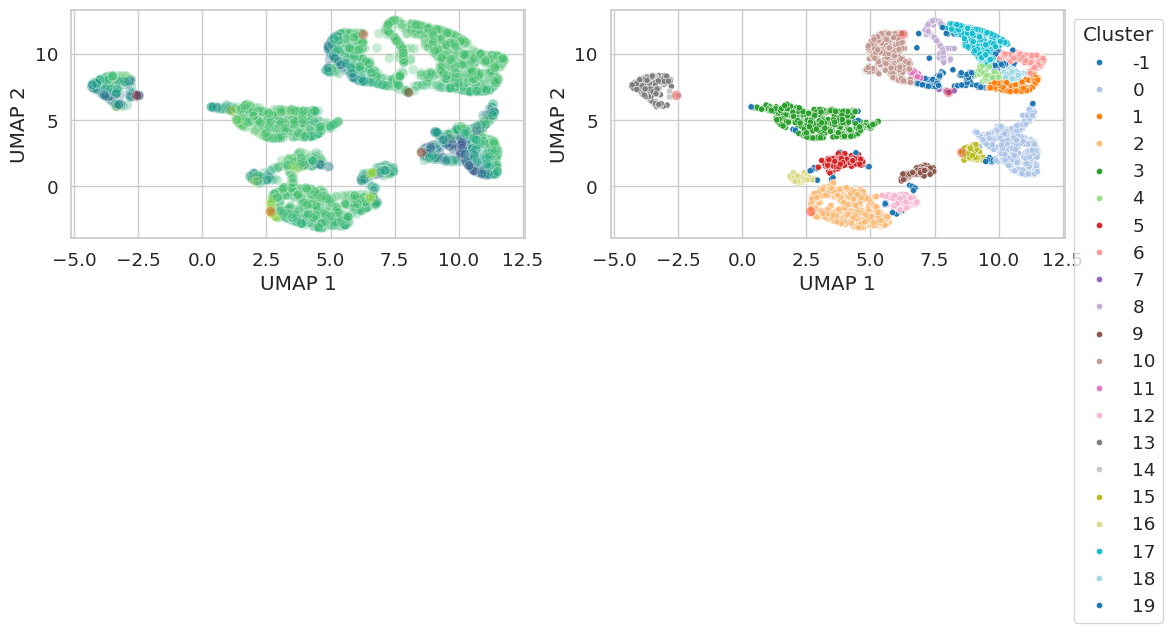

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(umap_result_df, x='UMAP 1', y='UMAP 2',
                hue='adaptation', palette='viridis', s=50, alpha=0.3, legend=False, ax=axs[0])
sns.scatterplot(umap_result_df[umap_result_df['Selected']],
                x='UMAP 1', y='UMAP 2', color='r', s=50, alpha=0.3, legend=False, ax=axs[0])
g = sns.scatterplot(umap_result_df, x='UMAP 1', y='UMAP 2', hue='Cluster', palette='tab20', s=20, ax=axs[1])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.scatterplot(umap_result_df[umap_result_df['Selected']],
                x='UMAP 1', y='UMAP 2', color='r', s=50, alpha=0.3, legend=False, ax=axs[1])
plt.tight_layout()

In [ ]:
# ts_og = np.load(os.path.join('data/simulate_circuits/2025_02_11__13_56_51', 'ts.npy'))
# ys_og = np.load(os.path.join('data/simulate_circuits/2025_02_11__13_56_51', 'ys.npy'))
# ys_sub = ys_og[data_test['circuit_name'].values]
ts_og = np.load(os.path.join(os.path.dirname(config_dataset.filenames_train_table), 'ts.npy'))
ys_og = np.load(os.path.join(os.path.dirname(config_dataset.filenames_train_table), 'ys.npy'))
ys_sub = ys_og[df['circuit_name'].values]
# ^^ They are the same
# data[data['sample_name'] == 'RNA_2'].iloc[267965][x_cols], df[df['circuit_name'] == 267965][x_cols]

In [ ]:
x_rev_all_og = x_datanormaliser.create_chain_preprocessor_inverse(
        x_methods_preprocessing)(x).reshape(-1, x.shape[-1]).squeeze()

0 [ -5.7199993 -10.109999   -0.         -0.        -12.209999   -0.       ]
1 [-2.93 -0.   -9.27 -0.   -9.01 -0.  ]
2 [ -0.        -0.        -8.540001  -0.        -0.       -17.82    ]
3 [ -0.         -2.2199998 -12.450001   -0.         -0.         -0.       ]
4 [-0.        -0.        -2.0700002 -0.        -0.        -0.       ]


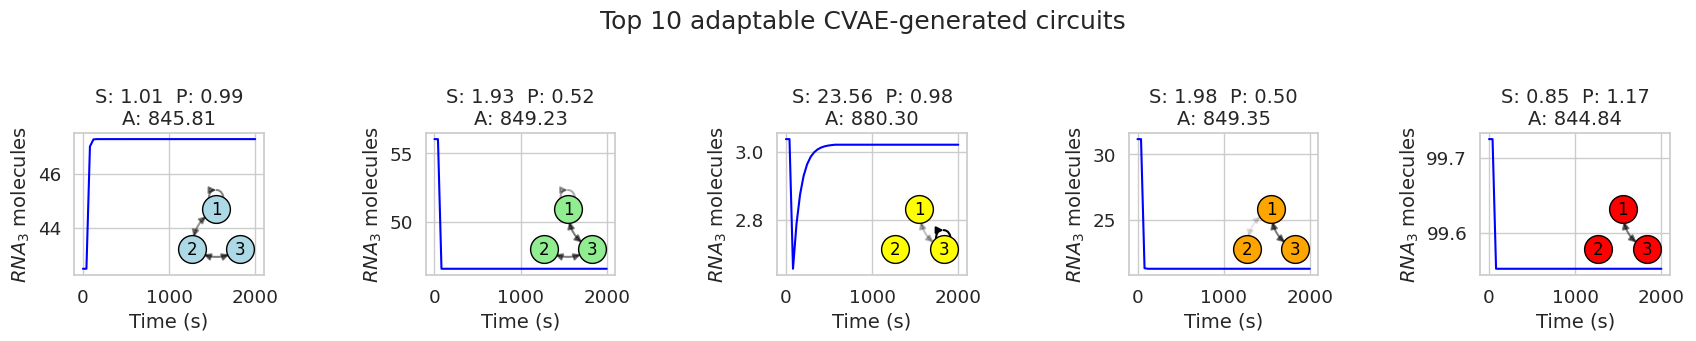

In [ ]:
ncols = len(idxs_adapt)
nrows = 1  # int(np.ceil(len(idxs_adapt) / ncols + 0.1))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                        figsize=(ncols * 3.5, nrows * 3.5), sharex=False, sharey=False)
if axs.ndim == 1:
    axs = axs[None, :]
t_plotmax = int(30000*0.8)
colors = ['lightblue', 'lightgreen', 'yellow', 'orange', 'red',
          'pink', 'purple', 'brown', 'grey', 'black', 'cyan', 'magenta']
for i, idx in enumerate(idxs_adapt):
    ax = axs[i // ncols, i % ncols]
    ax.plot(ts_og, ys_sub[idx, :, idx_output].T, color='b')
    # ax.plot(ts, ys[idx, :, idx_output].T, color='b')

    w = x_rev_all_og.reshape(np.prod(x_rev_all_og.shape[:-1]), -1)[idx]
    if (w > 0).sum() > 0:
        w = 1 - w
    print(i, w)
    # c = umap_result_df[umap_result_df["Index og"] == idx]["Cluster"].iloc[0]
    create_network_inset(fig, ax, width=0.9, height=0.9, edge_weights=make_nx_weights(
        w, n_nodes=3), node_color=colors[i])  # colors[int(c)-1])
    v = {k: np.array(source_frame[k])[idx, idx_output] if source_frame[k].ndim >
         1 else np.array(source_frame[k])[idx] for k in ['sensitivity', 'precision', 'adaptation']}
    ax.set_title(
        f'S: {v["sensitivity"]:.2f}  P: {v["precision"]:.2f}\nA: {v["adaptation"]:.2f}', fontsize=14)
    ax.set_xlabel('Time (s)', fontsize=14)
    ax.set_ylabel(f'$RNA_3$ molecules', fontsize=14)

plt.suptitle(f'Top {n_top} adaptable CVAE-generated circuits', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(top_write_dir,
            'best_performing_circuits_networks2.png'), dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
# y00s = np.load(os.path.join(os.path.dirname(config_dataset.filenames_train_table), 'y00s.npy'))
# ts0 = np.load(os.path.join(os.path.dirname(config_dataset.filenames_train_table), 'ts0.npy'))
# y00s_sub = y00s[df['circuit_name'].values]
# ys_full = np.concatenate([y00s_sub, ys_sub], axis=1)
# ts_full = np.concatenate([ts0, ts_og + ts0.max()], axis=0)

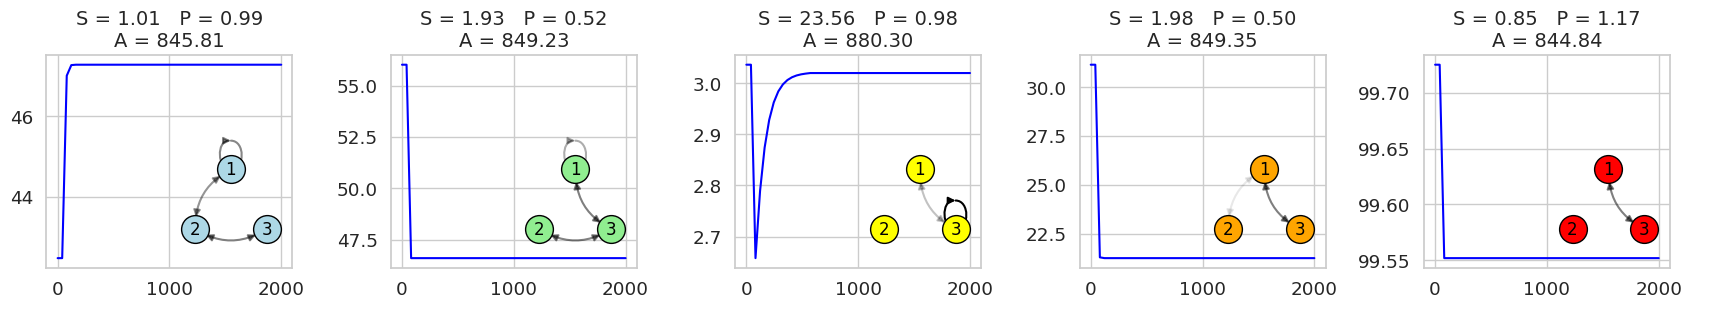

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=ncols,
                        figsize=(ncols * 3.5, 3.5), sharex=False, sharey=False)
for i, idx in enumerate(idxs_adapt):
    ax = axs[i % ncols]
    # ax.plot(ts_full, ys_full[idx, :, -3].T, color='b')
    # ax.set_ylim(0, None)
    ax.plot(ts_og, ys_sub[idx, :, idx_output].T, color='b')
    w = x_rev_all_og.reshape(np.prod(x_rev_all_og.shape[:-1]), -1)[idx]
    if (w > 0).sum() > 0:
        w = 1 - w
    # c = umap_result_df[umap_result_df["Index og"] == idx]["Cluster"].iloc[0]
    create_network_inset(fig, ax, width=0.9, height=0.9, edge_weights=make_nx_weights(
        w, n_nodes=3), node_color=colors[i])
    
    o1 = df["initial_steady_states"].iloc[idx]
    o2 = df["steady_states"].iloc[idx]
    ip = ys_sub[idx, :, -3].min()
    op = df["min_amount"].iloc[idx]
    i1 = ys_sub[idx, 0, -3]
    i2 = ys_sub[idx, -1, -3]
    ax.set_title(
        f'S = {df["sensitivity"].iloc[idx]:.2f}   P = {df["precision"].iloc[idx]:.2f}\nA = {df["adaptation"].iloc[idx]:.2f}' + 
        # f'\n$O_1$ = {o1:.2f}\t$O_2$ = {o2:.2f}\n$O_p$ = {op:.2f}' + 
        # f'\n$I_1$ = {i1:.2f}\t$I_2$ = {i2:.2f}\n$I_p$ = {ip:.2f}' + 
        # '\n' + 
        # f'\n$O_2 - O_1$ = {(o2 - o1):.2f}' + 
        # f'\n$(O_2 - O_1) / O_1$ = {(o2 - o1) / o1:.3f}' + 
        # f'\n$(O_p - O_1) / O_1$ = {(op - o1) / o1:.3f}' + 
        # f'\n$I_2 - I_1$ = {(i2 - i1):.2f}' +
        # f'\n$(I_2 - I_1) / I_1$ = {(i2 - i1) / i1:.3f}' + 
        # f'\n$(I_p - I_1) / I_1$ = {(ip - i1) / i1:.3f}' + 
        # '\n' + 
        # f'\nP = {(i2 - i1) / i1:.3f}/' +
        # f'{(o2 - o1) / o1:.3f} = ' + 
        # f'{((i2 - i1) / i1) / ((o2 - o1) / o1):.3f}' + 
        # f'\nS = {(op - o1) / o1:.3f}/{(ip - i1) / i1:.3f} = {((op - o1) / o1) / ((ip - i1) / i1):.3f}\n', fontsize=14)
        '', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(wspace=0.4)
plt.savefig(os.path.join(top_write_dir,
            'best_performing_circuits_networks3.png'), dpi=300, bbox_inches='tight', transparent=True)


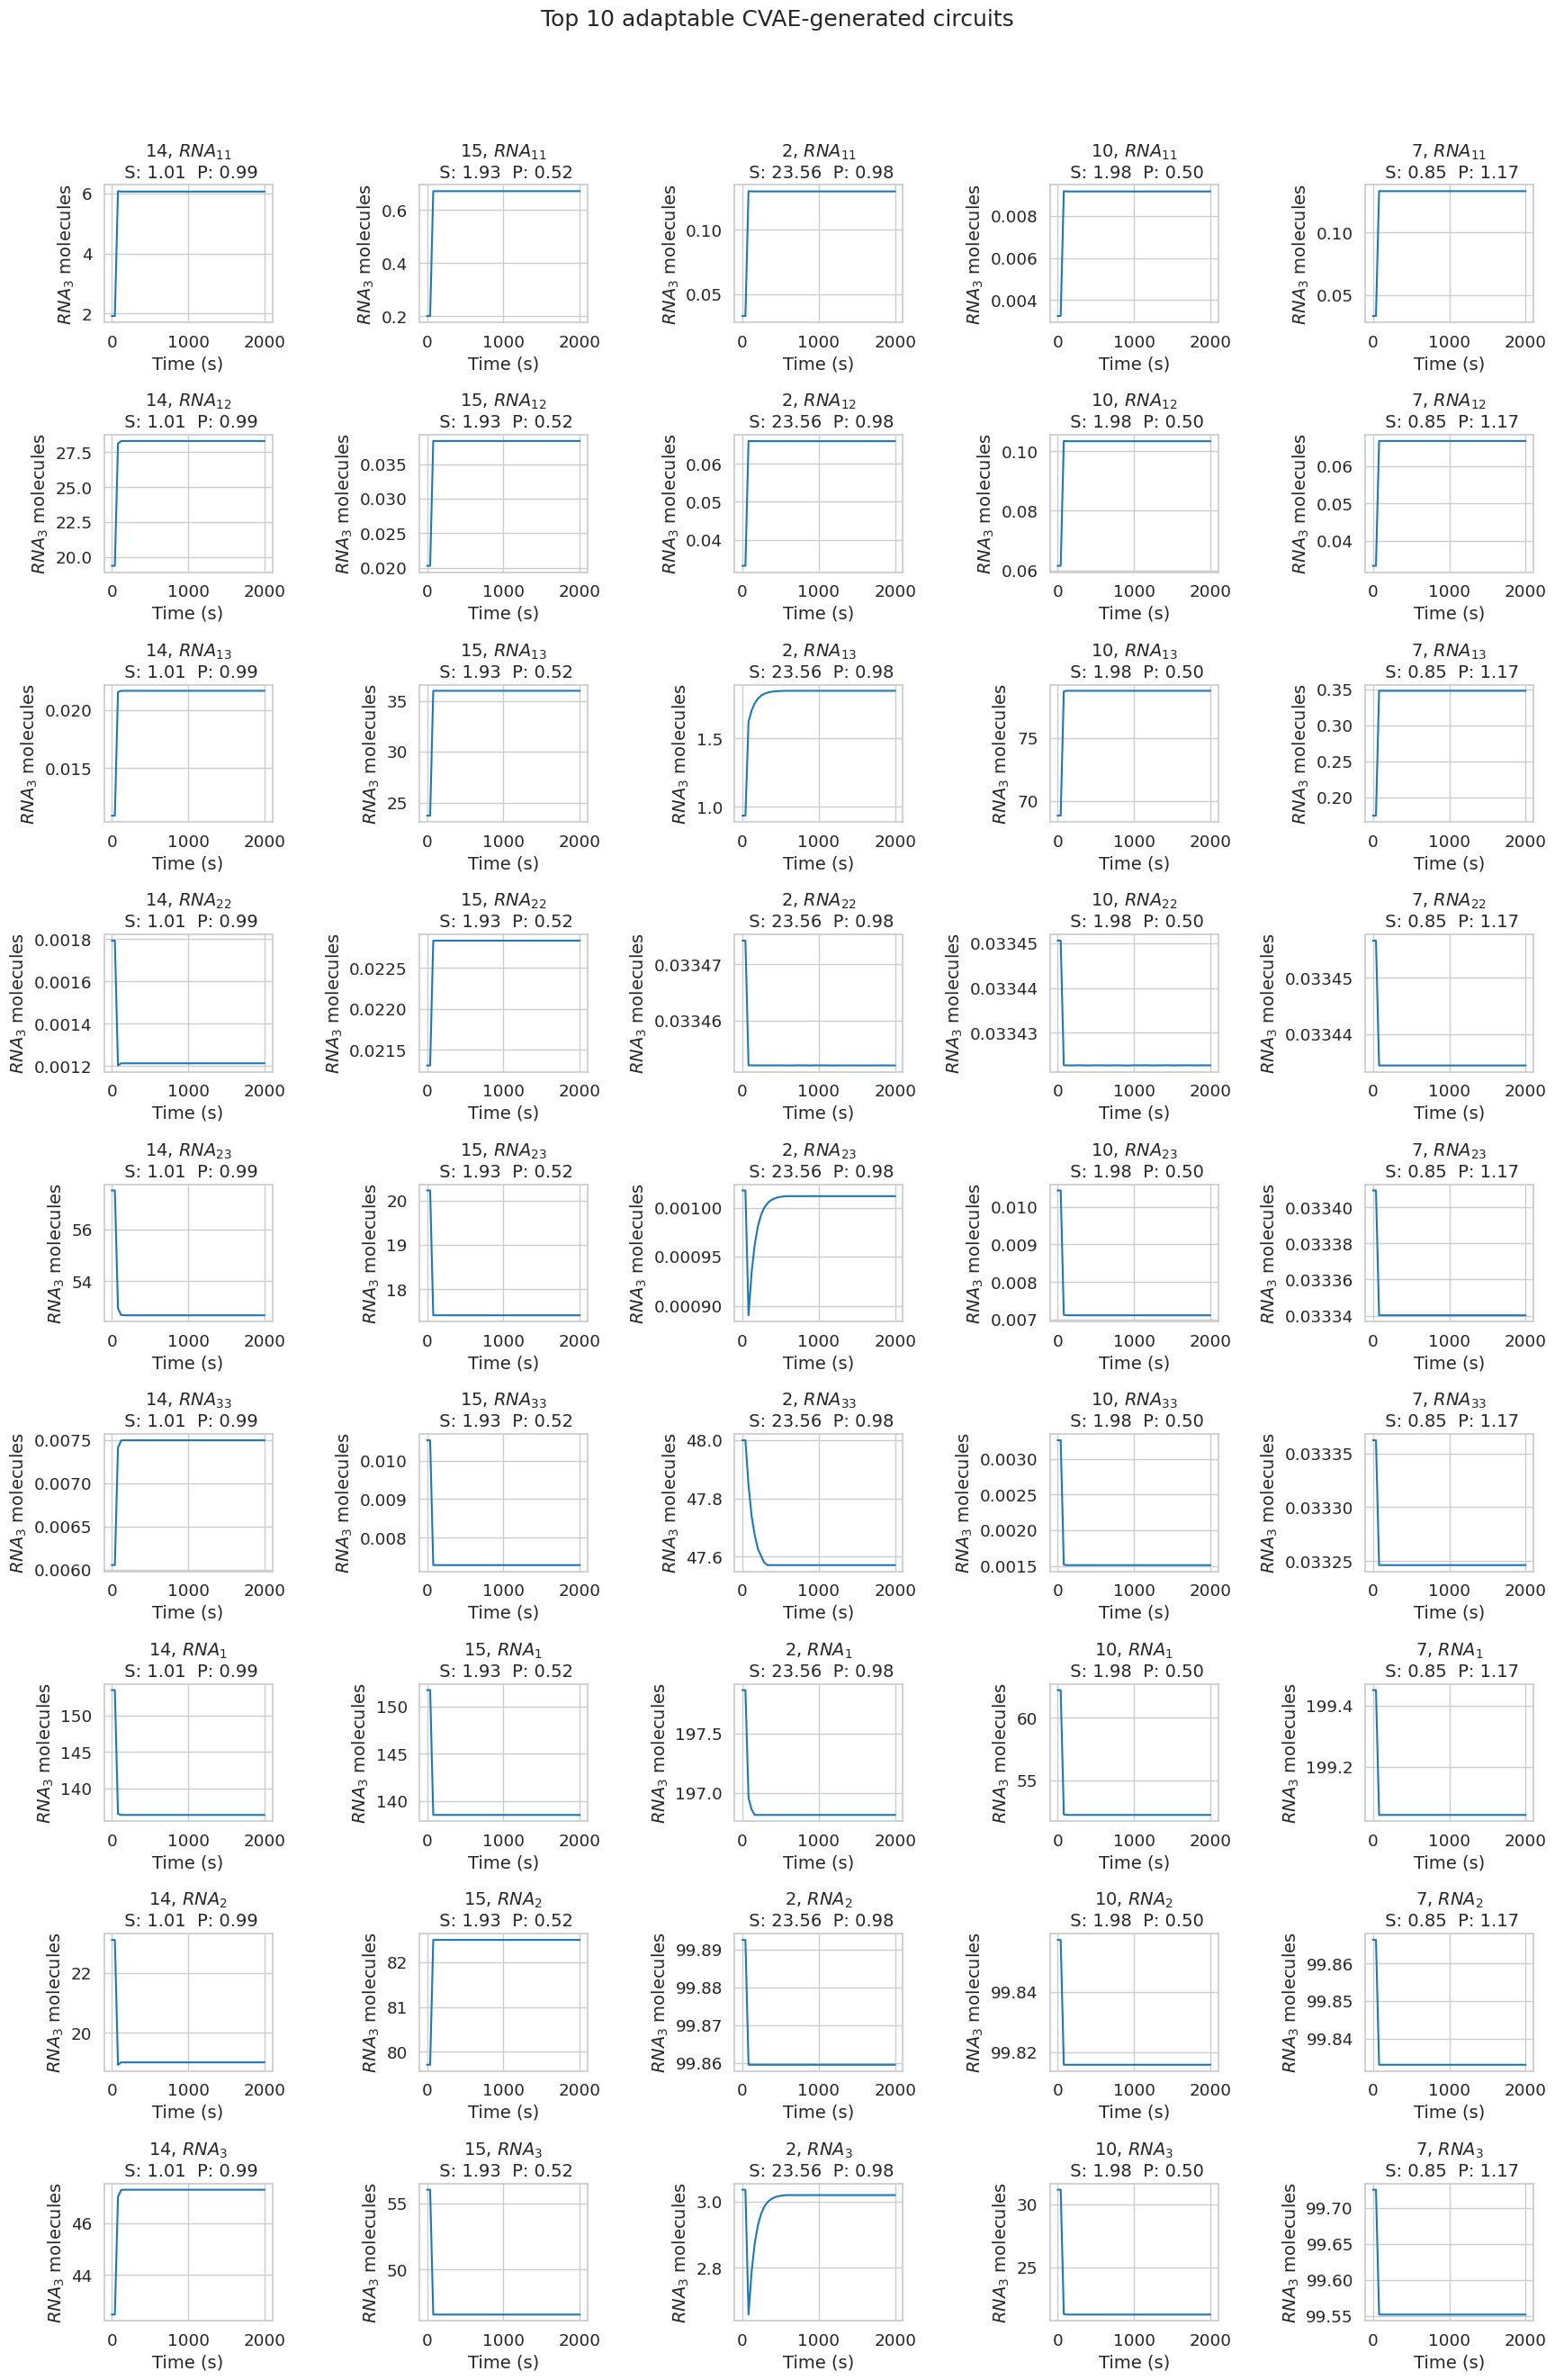

In [ ]:
spec_labels = ['11', '12', '13', '22', '23', '33', '1', '2', '3']
nrows = len(spec_labels)
ncols = len(idxs_adapt)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                        figsize=(ncols * 3.5, nrows * 3), sharex=False, sharey=False)
for ii, (idx_spec, label_spec) in enumerate(zip(range(len(spec_labels)), spec_labels)):
    for i, idx in enumerate(idxs_adapt):
        i = ii * len(idxs_adapt) + i
        ax = axs[i // ncols, i % ncols]
        ax.plot(ts_og, ys_sub[idx, :, idx_spec].T)
        c = umap_result_df[umap_result_df["Index og"] == idx]["Cluster"].iloc[0]
        ax.set_title(
            f'{c}, $RNA_{{{label_spec}}}$\n S: {df["sensitivity"].iloc[idx]:.2f}  P: {df["precision"].iloc[idx]:.2f}', fontsize=14)
        ax.set_xlabel('Time (s)', fontsize=14)
        ax.set_ylabel(f'$RNA_3$ molecules', fontsize=14)
        # if i == len(idxs_adapt) - 1:
        #     ax.legend(spec_labels, title='Species')
        #     sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
        # plt.legend(['11', '12', '13', '22', '23', '33', '1', '2', '3'], title='Species', loc='upper right')


plt.suptitle(f'Top {n_top} adaptable CVAE-generated circuits', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])


# Model's best circuit

Is there a circuit generated by the model that's better than anything in the training data?

In [ ]:
use_loaded = False

if use_loaded:
    # 2025_01_17__16_33_03
    # 2025_01_14__18_00_06
    # 2025_01_10__16_31_12
    analytics = load_json_as_dict(os.path.join(
        'data/02_cvae_verify/2025_01_17__16_33_03', 'analytics.json'))
    fake_circuits = np.load(os.path.join(
        'data/02_cvae_verify/2025_01_17__16_33_03', 'fake_circuits.npy'))
    ts = np.load(os.path.join(
        'data/02_cvae_verify/2025_01_17__16_33_03', 'ts.npy'))
    sampled_cond = np.load(os.path.join(
        'data/02_cvae_verify/2025_01_21__16_23_09', 'sampled_cond.npy'))
    for k in analytics.keys():
        analytics[k] = np.array(analytics[k])
    if 'Log sensitivity' not in analytics:
        analytics['Log sensitivity'] = np.log10(analytics['sensitivity'])
        analytics['Log precision'] = np.log10(analytics['precision'])
    analytics['adaptation'] = calculate_adaptation(
        analytics['sensitivity'], analytics['precision'], alpha=2)

In [ ]:
data['adaptation'] = calculate_adaptation(np.array(data['sensitivity']), np.array(data['precision']), alpha=2)
analytics['adaptation'] = calculate_adaptation(analytics['sensitivity'], analytics['precision'], alpha=2)
df_analytics = pd.DataFrame({k: v.flatten() for k, v in analytics.items()})
df_analytics['sample_name'] = np.repeat(np.arange(9)[:, None], repeats=len(df_analytics)//9, axis=1).T.flatten()

In [ ]:
output_idx = -1
print('Max s1\tMax s2\tMax a\tSens at max adapt')

output_training = {}
output_model = {}
for k in ['Max response time', 'Max log10 sensitivity', 'Max adaptation', 'Max sensitivity at max adaptation', 'Max precision at max adaptation']:
    output_training.setdefault(k, [])
    output_model.setdefault(k, [])
dt = 0.01
for p in np.arange(0 + dt, 1 + dt, dt):
    filt = (np.abs(data['Log sensitivity']) < np.inf) & data['sample_name'].isin(
        ['RNA_2']) & (data['response_time'] < (p*ts.max()))
    filt2 = (df_analytics['response_time']
             < (p*ts.max())) & (df_analytics['sample_name'] == 8)
    # stats = (np.max(df_analytics[filt2]['Log sensitivity']),
    #       np.max(data[filt]['Log sensitivity']),
    #       np.max(data[filt]['adaptation']),
    #       data[filt & (data['adaptation'] == np.max(data[filt]['adaptation']))]['Log sensitivity'].iloc[0])
    # print(''.join([f'{s:.2f}\t' for s in stats]))
    
    output_training['Max response time'].append(p*ts.max())
    output_training['Max log10 sensitivity'].append(np.max(data[filt]['Log sensitivity']))
    output_training['Max adaptation'].append(np.max(data[filt]['adaptation']))
    output_training['Max sensitivity at max adaptation'].append(data[filt & (data['adaptation'] == np.max(data[filt]['adaptation']))]['Log sensitivity'].iloc[0])
    output_training['Max precision at max adaptation'].append(data[filt & (data['adaptation'] == np.max(data[filt]['adaptation']))]['Log precision'].iloc[0])
    
    output_model['Max response time'].append(p*ts.max())
    output_model['Max log10 sensitivity'].append(np.max(df_analytics[filt2]['Log sensitivity']))
    output_model['Max adaptation'].append(np.max(df_analytics[filt2]['adaptation']))
    output_model['Max sensitivity at max adaptation'].append(df_analytics[filt2 & (df_analytics['adaptation'] == np.max(df_analytics[filt2]['adaptation']))]['Log sensitivity'].iloc[0])
    output_model['Max precision at max adaptation'].append(df_analytics[filt2 & (df_analytics['adaptation'] == np.max(df_analytics[filt2]['adaptation']))]['Log precision'].iloc[0])

Max s1	Max s2	Max a	Sens at max adapt


In [ ]:
output_training = pd.DataFrame(output_training)
output_training['Source'] = 'Training data'
output_model = pd.DataFrame(output_model)
output_model['Source'] = 'Model generated'

df_maxes = pd.concat([output_training, output_model]).reset_index(drop=True)

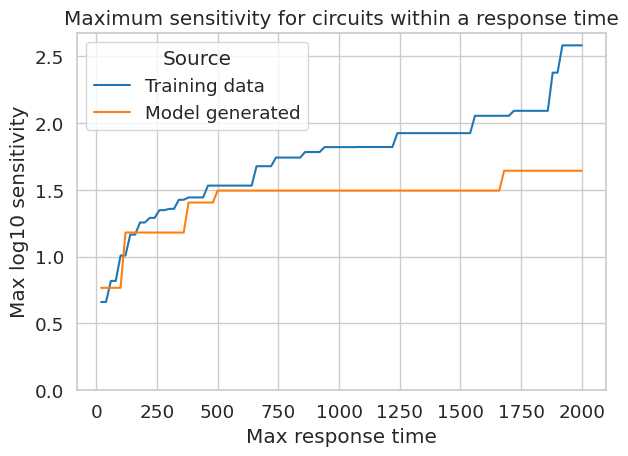

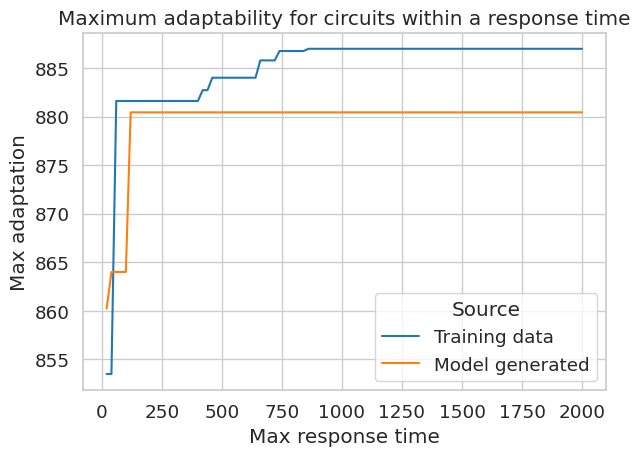

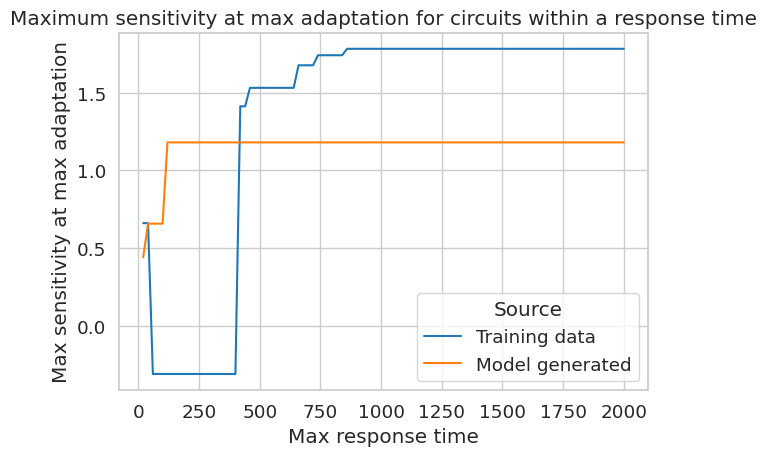

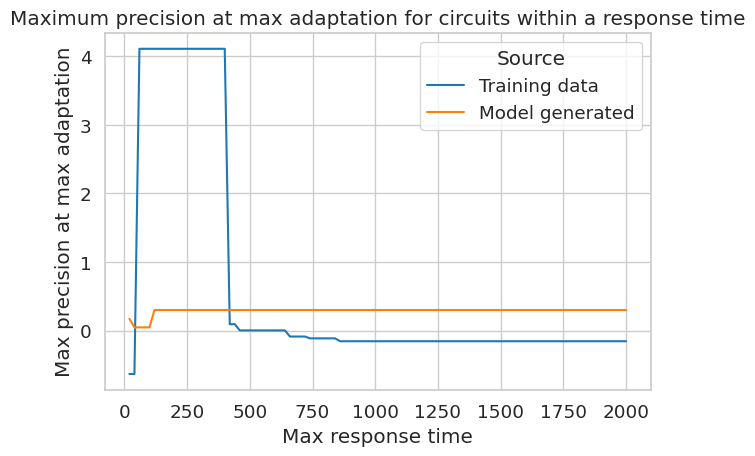

In [ ]:
sns.lineplot(df_maxes, x='Max response time', y='Max log10 sensitivity', hue='Source')
plt.ylim(0, None)
plt.title('Maximum sensitivity for circuits within a response time')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'line_max_sens.png'), dpi=300, transparent=True)

plt.figure()
sns.lineplot(df_maxes, x='Max response time', y='Max adaptation', hue='Source')
plt.title('Maximum adaptability for circuits within a response time')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'line_max_adapt.png'), dpi=300, transparent=True)

plt.figure()
sns.lineplot(df_maxes, x='Max response time', y='Max sensitivity at max adaptation', hue='Source')
plt.title('Maximum sensitivity at max adaptation for circuits within a response time')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'line_max_maxadaptsens.png'), dpi=300, transparent=True)

plt.figure()
sns.lineplot(df_maxes, x='Max response time', y='Max precision at max adaptation', hue='Source')
plt.title('Maximum precision at max adaptation for circuits within a response time')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'line_max_maxadaptprec.png'), dpi=300, transparent=True)

